In [20]:
# ==========================================
# CELL 1: Setup & Dependencies
# ==========================================

!pip install roboflow ultralytics torch torchvision opencv-python pillow pandas numpy pyyaml
!pip install scikit-learn matplotlib seaborn tqdm

# Download dataset
from roboflow import Roboflow
rf = Roboflow(api_key="blm6FIqi33eLS0ewVlKV")
project = rf.workspace("2642025").project("19-06")
version = project.version(7)
dataset = version.download("yolov12")

print("✅ Dependencies installed and dataset downloaded!")


loading Roboflow workspace...
loading Roboflow project...
✅ Dependencies installed and dataset downloaded!


In [ ]:
# ==========================================
# CELL 2: Clone Repository & Download Models
# ==========================================

import subprocess
import sys
import os

# Clone repository
print("📥 Cloning repository...")
result = subprocess.run([
    'git', 'clone',
    'https://github.com/hoangh-e/dog-emotion-recognition-hybrid.git'
], capture_output=True, text=True)

# Download models
print("📥 Downloading models...")
# Download head detection model only
!gdown 1gK51jAz1gzYad7-UcDMmuH7bq849DOjz --output yolov12m_dog_head_1cls_100ep_best_v1.pt

# Optional: Download emotion classification models for comparison
!gdown 1s5KprrhHWkbhjRWCb3OK48I-OriDLR_S --output resnet50_50e_best.pth
!gdown 1zwXbvUYHH62CcwAgkDX-9PdeSfRn2ngb --output resnet50_30e_best.pth
!gdown 1AU3zjUYvfPjK5nxsXihQQ175AT0Ex7tH --output resnet101_30e_best.pth
!gdown 11Oy8lqKF7MeMWV89SR-kN6sNLwNi-jjQ --output pure34_30e_best.pth
!gdown 19YOIURvPQ89AGHxiafqaILr-tDuN8FIa --output pure50_30e_best.pth
!gdown 1GTUXZxivkn7yALZRYLHKbv_dKlBPbnL5 --output pure50_50e_best.pth


print("✅ Repository cloned and models downloaded!")


📥 Cloning repository...
📥 Downloading models...
Downloading...
From: https://drive.google.com/uc?id=1gK51jAz1gzYad7-UcDMmuH7bq849DOjz
To: /content/yolov12m_dog_head_1cls_100ep_best_v1.pt
100% 10.8M/10.8M [00:00<00:00, 37.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_543yUfdA6DDaOJatgZ0jNGNZgNOGt6M
From (redirected): https://drive.google.com/uc?id=1_543yUfdA6DDaOJatgZ0jNGNZgNOGt6M&confirm=t&uuid=b4f5163c-483a-4a9b-b19d-ecce3fa77712
To: /content/yolov12m_dog_tail_3cls_80ep_best_v2.pt
100% 40.8M/40.8M [00:00<00:00, 52.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1s5KprrhHWkbhjRWCb3OK48I-OriDLR_S
From (redirected): https://drive.google.com/uc?id=1s5KprrhHWkbhjRWCb3OK48I-OriDLR_S&confirm=t&uuid=0afd56ae-1a2f-4198-a971-11bfa84454ce
To: /content/resnet50_50e_best.pth
100% 94.4M/94.4M [00:00<00:00, 113MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1zwXbvUYHH62CcwAgkDX-9PdeSfRn2ngb
From (redirected): https://drive.google.c

In [22]:
# ==========================================
# CELL 3: Import Libraries
# ==========================================

import os
import cv2
import torch
import pandas as pd
import numpy as np
import yaml
from pathlib import Path
from PIL import Image
import torchvision.transforms as transforms
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from collections import defaultdict
import json
from datetime import datetime

warnings.filterwarnings('ignore')

print("📦 All packages imported successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🚀 CUDA available: {torch.cuda.is_available()}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")


📦 All packages imported successfully!
🔥 PyTorch version: 2.6.0+cu124
🚀 CUDA available: True
🖥️ Using device: cuda


In [ ]:
# ==========================================
# CELL 4: Multi-Model Configuration
# ==========================================

# Dataset configuration
DATASET_PATH = "/content/19/06-7/test"
YOLO_HEAD_MODEL = "/content/yolov12m_dog_head_1cls_100ep_best_v1.pt"


# resnet50_50e_best.pth
# resnet50_30e_best.pth
# resnet101_30e_best.pth
# pure34_30e_best.pth
# pure50_30e_best.pth
# pure50_50e_best.pth
# ===== 🚀 MULTI-MODEL CONFIGURATION =====
EMOTION_MODELS = {
    'pure34_30e': {
        'path': '/content/pure34_30e_best.pth',
        'type': 'pure34',
        'input_size': 512,
        'classes': ['sad', 'angry', 'happy', 'relaxed'],
        'enabled': os.path.exists('/content/pure34_30e_best.pth')
    },
    'pure50_30e': {
        'path': '/content/pure50_30e_best.pth',
        'type': 'pure50',
        'input_size': 512,
        'classes': ['sad', 'angry', 'happy', 'relaxed'],
        'enabled': os.path.exists('/content/pure50_30e_best.pth')
    },
     'pure50_50e': {
        'path': '/content/pure50_50e_best.pth',
        'type': 'pure50',
        'input_size': 512,
        'classes': ['sad', 'angry', 'happy', 'relaxed'],
        'enabled': os.path.exists('/content/pure50_50e_best.pth')
    },
    'resnet50_50e': {
        'path': '/content/resnet50_50e_best.pth',
        'type': 'resnet',
        'architecture': 'resnet50',
        'input_size': 224,
        'classes': ['sad', 'angry', 'happy', 'relaxed'],
        'enabled': os.path.exists('/content/resnet50_50e_best.pth') # Set to True when model is available
    },
    'resnet50_30e': {
        'path': '/content/resnet50_30e_best.pth',
        'type': 'resnet',
        'architecture': 'resnet50',
        'input_size': 224,
        'classes': ['sad', 'angry', 'happy', 'relaxed'],
        'enabled': os.path.exists('/content/resnet50_30e_best.pth') # Set to True when model is available
    },
    'resnet101_30e': {
        'path': '/content/resnet101_30e_best.pth',
        'type': 'resnet',
        'architecture': 'resnet101',
        'input_size': 224,
        'classes': ['sad', 'angry', 'happy', 'relaxed'],
        'enabled': os.path.exists('/content/resnet101_30e_best.pth') # Set to True when model is available
    }
}

# Output configuration
OUTPUT_DIR = "/content/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Filter enabled models
ENABLED_MODELS = {name: config for name, config in EMOTION_MODELS.items() if config['enabled']}

print("🔧 MULTI-MODEL CONFIGURATION")
print("=" * 60)
print(f"📂 Dataset: {DATASET_PATH}")
print(f"🎯 YOLO Head: {YOLO_HEAD_MODEL}")
print(f"📁 Output Directory: {OUTPUT_DIR}")

print(f"\n🧠 EMOTION MODELS CONFIGURATION:")
print(f"   Total models defined: {len(EMOTION_MODELS)}")
print(f"   Enabled models: {len(ENABLED_MODELS)}")

for name, config in EMOTION_MODELS.items():
    status = "✅ ENABLED" if config['enabled'] else "❌ DISABLED"
    exists = "📁 EXISTS" if os.path.exists(config['path']) else "❌ NOT FOUND"
    print(f"   {name:12s}: {status:12s} | {exists:12s} | {config['type']:8s} | {config['input_size']}x{config['input_size']}")

print("=" * 60)

🔧 MULTI-MODEL CONFIGURATION
📂 Dataset: /content/19/06-7/test
🎯 YOLO Head: /content/yolov12m_dog_head_1cls_100ep_best_v1.pt
🎯 YOLO Tail: /content/yolov12m_dog_tail_3cls_80ep_best_v2.pt
📁 Output Directory: /content/outputs

🧠 EMOTION MODELS CONFIGURATION:
   Total models defined: 6
   Enabled models: 6
   pure34_30e  : ✅ ENABLED    | 📁 EXISTS     | pure34   | 512x512
   pure50_30e  : ✅ ENABLED    | 📁 EXISTS     | pure50   | 512x512
   pure50_50e  : ✅ ENABLED    | 📁 EXISTS     | pure50   | 512x512
   resnet50_50e: ✅ ENABLED    | 📁 EXISTS     | resnet   | 224x224
   resnet50_30e: ✅ ENABLED    | 📁 EXISTS     | resnet   | 224x224
   resnet101_30e: ✅ ENABLED    | 📁 EXISTS     | resnet   | 224x224


In [24]:
# ==========================================
# CELL 5: Multi-Model Validation & Setup
# ==========================================

# Validation logic
if len(ENABLED_MODELS) < 2:
    print("⚠️ SINGLE MODEL MODE")
    print("=" * 50)
    print(f"Only {len(ENABLED_MODELS)} model(s) enabled.")
    print("Multi-model comparison will be DISABLED.")
    print("Standard single-model processing will be used.")
    MULTI_MODEL_MODE = False
else:
    print("🚀 MULTI-MODEL MODE ACTIVATED")
    print("=" * 50)
    print(f"✅ {len(ENABLED_MODELS)} models enabled")
    print("✅ Multi-model comparison ENABLED")
    print("✅ Individual CSV generation ENABLED")
    print("✅ Advanced analysis ENABLED")
    MULTI_MODEL_MODE = True

print(f"\n📋 Enabled models for processing:")
for name, config in ENABLED_MODELS.items():
    print(f"   🧠 {name}: {config['type']} ({config['input_size']}x{config['input_size']})")

# Model-specific output paths
MODEL_OUTPUTS = {}
for name in ENABLED_MODELS.keys():
    MODEL_OUTPUTS[name] = {
        'raw_csv': f"{OUTPUT_DIR}/raw_predictions_{name}.csv",
        'processed_csv': f"{OUTPUT_DIR}/processed_dataset_{name}.csv"
    }

if MULTI_MODEL_MODE:
    MODEL_OUTPUTS['comparison'] = {
        'comparison_csv': f"{OUTPUT_DIR}/model_comparison.csv",
        'analysis_json': f"{OUTPUT_DIR}/analysis_results.json",
        'charts_dir': f"{OUTPUT_DIR}/comparison_charts"
    }
    os.makedirs(MODEL_OUTPUTS['comparison']['charts_dir'], exist_ok=True)

print(f"\n📁 Output file structure prepared:")
for model_name, paths in MODEL_OUTPUTS.items():
    print(f"   {model_name}:")
    for file_type, path in paths.items():
        print(f"      {file_type}: {path}")

print("=" * 50)


🚀 MULTI-MODEL MODE ACTIVATED
✅ 6 models enabled
✅ Multi-model comparison ENABLED
✅ Individual CSV generation ENABLED
✅ Advanced analysis ENABLED

📋 Enabled models for processing:
   🧠 pure34_30e: pure34 (512x512)
   🧠 pure50_30e: pure50 (512x512)
   🧠 pure50_50e: pure50 (512x512)
   🧠 resnet50_50e: resnet (224x224)
   🧠 resnet50_30e: resnet (224x224)
   🧠 resnet101_30e: resnet (224x224)

📁 Output file structure prepared:
   pure34_30e:
      raw_csv: /content/outputs/raw_predictions_pure34_30e.csv
      processed_csv: /content/outputs/processed_dataset_pure34_30e.csv
   pure50_30e:
      raw_csv: /content/outputs/raw_predictions_pure50_30e.csv
      processed_csv: /content/outputs/processed_dataset_pure50_30e.csv
   pure50_50e:
      raw_csv: /content/outputs/raw_predictions_pure50_50e.csv
      processed_csv: /content/outputs/processed_dataset_pure50_50e.csv
   resnet50_50e:
      raw_csv: /content/outputs/raw_predictions_resnet50_50e.csv
      processed_csv: /content/outputs/processe

In [ ]:
# ==========================================
# CELL 6: Load YOLO Head Model
# ==========================================

print("🔄 Loading YOLO head model...")

try:
    # YOLO Head Detection Model (1 class: dog head)
    yolo_head_model = YOLO(YOLO_HEAD_MODEL)
    print(f"✅ YOLO Head model loaded successfully")
    print(f"   Classes: {yolo_head_model.names}")

except Exception as e:
    print(f"❌ Error loading YOLO head model: {e}")
    raise

print("✅ YOLO head model ready!")


🔄 Loading YOLO models...
✅ YOLO Tail model loaded successfully
   Classes: {0: 'DownTail', 1: 'MidTail', 2: 'UpTail'}
✅ YOLO Head model loaded successfully
   Classes: {0: 'Head'}
✅ YOLO models ready!


In [ ]:
def predict_emotion_classification_multi(image_path, model_name, head_bbox=None):
    """
    🧠 Predict emotion using specified model from loaded models

    Parameters:
    -----------
    image_path : str or PosixPath
        Path to input image
    model_name : str
        Name of the model to use (from loaded_models)
    head_bbox : list, optional
        Head bounding box [x1, y1, x2, y2]

    Returns:
    --------
    dict: {'sad': float, 'angry': float, 'happy': float, 'relaxed': float, 'predicted': bool}
    """
    try:
        if model_name not in loaded_models:
            raise ValueError(f"Model {model_name} not loaded")

        model = loaded_models[model_name]
        transform = model_transforms[model_name]
        predict_func = model_predict_functions[model_name]

        # 🔧 FIX: Convert PosixPath to string for all models
        image_path_str = str(image_path)

        # Use the appropriate prediction function
        emotion_scores = predict_func(
            image_path=image_path_str,  # ✅ Always pass as string
            model=model,
            transform=transform,
            head_bbox=head_bbox,
            device=device
        )

        return emotion_scores

    except Exception as e:
        print(f"❌ Error in emotion classification with {model_name} for {image_path}: {e}")
        return {'sad': 0.0, 'angry': 0.0, 'happy': 0.0, 'relaxed': 0.0, 'predicted': False}

print("✅ Multi-model emotion prediction function defined (FIXED)")

# Assuming the following variables are defined: image_files, progress_interval, total_images, yolo_head_model, yolo_tail_model, get_manual_label_from_filename, loaded_models, model_results

for i, image_path in enumerate(image_files):
    # Progress indicator
    if i % progress_interval == 0 or i == total_images - 1:
        progress = (i + 1) / total_images * 100
        print(f"📊 Progress: {i+1}/{total_images} ({progress:.1f}%) - {image_path.name}")

    try:
        # 1. Head detection (shared for all models)
        head_result = predict_head_detection(image_path, yolo_head_model)

        # 2. Tail detection (shared for all models)
        tail_result = predict_tail_detection(image_path, yolo_tail_model)

        # 3. ⚠️ FILTERING: Skip image if head not detected (tail detection is now optional)
        if not head_result['detected']:
            skipped_count += 1
            print(f"   ⚠️  Skipped {image_path.name}: HEAD not detected")
            continue

        # UPDATED: Tail detection is now optional - images will be processed even if tail is not detected
        # if not tail_result['detected']:
        #     skipped_count += 1
        #     print(f"   ⚠️  Skipped {image_path.name}: TAIL not detected")
        #     continue

        # 4. Get manual label
        manual_label = get_manual_label_from_filename(image_path)

        # 5. PROCESS WITH ALL MODELS
        image_processed = False

        for model_name in loaded_models.keys():
            try:
                # Emotion classification with current model
                emotion_result = predict_emotion_classification(
                    image_path,
                    loaded_models[model_name],
                    head_bbox=head_result['bbox']
                )

                # Create row data for this model
                row = {
                    'filename': image_path.name,
                    'sad': emotion_result['sad'],
                    'angry': emotion_result['angry'],
                    'happy': emotion_result['happy'],
                    'relaxed': emotion_result['relaxed'],
                    'down': tail_result['down'],
                    'up': tail_result['up'],
                    'mid': tail_result['mid'],
                    'label': manual_label,
                    'head_confidence': head_result['confidence'],
                    'head_bbox': str(head_result['bbox']),
                    'model_name': model_name
                }

                model_results[model_name].append(row)
                image_processed = True

            except Exception as e:
                print(f"   ❌ Error with {model_name} on {image_path.name}: {e}")
                continue

        if image_processed:
            processed_count += 1
            # Show successful processing for first few images
            if processed_count <= 3:
                successful_models = [m for m in loaded_models.keys() if len([r for r in model_results[m] if r['filename'] == image_path.name]) > 0]
                print(f"   ✅ Processed {image_path.name} with {len(successful_models)} models")
        else:
            skipped_count += 1
            print(f"   ⚠️  Skipped {image_path.name}: All models failed")

    except Exception as e:
        error_count += 1
        print(f"   ❌ Error processing {image_path.name}: {e}")
        continue

✅ Multi-model emotion prediction function defined (FIXED)


In [27]:
# ==========================================
# CELL 7: Load Emotion Models (UPDATED)
# ==========================================

# Add the package to path
sys.path.append('/content/dog-emotion-recognition-hybrid')

# Import ALL model loading functions
from dog_emotion_classification import (
    load_pure34_model, predict_emotion_pure34,
    load_pure50_model, predict_emotion_pure50,
    load_resnet_emotion_model, predict_emotion_resnet
)

# Storage for loaded models
loaded_models = {}
model_transforms = {}
model_predict_functions = {}

print("🔄 Loading emotion classification models...")
print("=" * 50)

for model_name, config in ENABLED_MODELS.items():
    try:
        print(f"Loading {model_name} ({config['type']})...")

        if config['type'] == 'pure34':
            # Load Pure34 model
            model, transform = load_pure34_model(
                model_path=config['path'],
                num_classes=len(config['classes']),
                device=device
            )
            predict_func = predict_emotion_pure34
            print(f"✅ {model_name} loaded successfully (Pure34)")

        elif config['type'] == 'pure50':
            # Load Pure50 model
            model, transform = load_pure50_model(
                model_path=config['path'],
                num_classes=len(config['classes']),
                input_size=config['input_size'],
                device=device
            )
            predict_func = predict_emotion_pure50
            print(f"✅ {model_name} loaded successfully (Pure50)")

        elif config['type'] == 'resnet':
            # Load ResNet model
            model, transform = load_resnet_emotion_model(
                model_path=config['path'],
                architecture=config['architecture'],  # resnet50, resnet101
                num_classes=len(config['classes']),
                input_size=config['input_size'],
                device=device
            )
            predict_func = predict_emotion_resnet
            print(f"✅ {model_name} loaded successfully ({config['architecture'].upper()})")

        else:
            print(f"❌ Unknown model type for {model_name}: {config['type']}")
            continue

        # Store successfully loaded models
        loaded_models[model_name] = model
        model_transforms[model_name] = transform
        model_predict_functions[model_name] = predict_func

    except Exception as e:
        print(f"❌ Error loading {model_name}: {e}")
        # Remove from enabled models if loading fails
        if model_name in ENABLED_MODELS:
            del ENABLED_MODELS[model_name]

print("=" * 50)
print(f"📊 LOADING SUMMARY:")
print(f"   Successfully loaded: {len(loaded_models)} models")
print(f"   Available for processing: {list(loaded_models.keys())}")

# Update multi-model mode based on actually loaded models
MULTI_MODEL_MODE = len(loaded_models) >= 2

if MULTI_MODEL_MODE:
    print(f"✅ Multi-model mode ENABLED with {len(loaded_models)} models")
else:
    print(f"⚠️ Multi-model mode DISABLED - only {len(loaded_models)} model(s) loaded")

EMOTION_CLASSES = ['sad', 'angry', 'happy', 'relaxed']
print(f"🎭 Emotion classes: {EMOTION_CLASSES}")
print("=" * 50)

🔄 Loading emotion classification models...
Loading pure34_30e (pure34)...
🔄 Loading model from: /content/pure34_30e_best.pth
🔍 Analyzing checkpoint structure...
📦 Checkpoint format: ['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1

In [ ]:
# ==========================================
# CELL 8: YOLO Head Detection Function
# ==========================================

# Import bbox validation functions
try:
    from dog_emotion_ml import (
        calculate_iou,
        get_ground_truth_bbox,
        validate_head_detection_with_ground_truth
    )
    BBOX_VALIDATION_AVAILABLE = True
    print("✅ Bbox validation functions imported")
except ImportError as e:
    print(f"⚠️ dog_emotion_ml package not available: {e}")
    BBOX_VALIDATION_AVAILABLE = False

def predict_head_detection(image_path, model, confidence_threshold=0.5, enable_bbox_validation=True, iou_threshold=0.3):
    """🎯 Predict dog head detection using YOLO with optional bbox validation"""
    try:
        results = model(image_path, verbose=False)

        best_detection = None
        best_confidence = 0.0
        validation_details = []

        for result in results:
            if result.boxes is not None:
                for box in result.boxes:
                    class_id = int(box.cls)
                    confidence = float(box.conf)

                    if confidence > confidence_threshold:
                        bbox = box.xyxy[0].cpu().numpy().tolist()

                        # Validate bbox với ground truth nếu được enable
                        validation_result = {'valid': True, 'reason': 'No validation'}
                        if enable_bbox_validation and BBOX_VALIDATION_AVAILABLE:
                            validation_result = validate_head_detection_with_ground_truth(
                                bbox, image_path, iou_threshold
                            )
                            validation_details.append({
                                'bbox': bbox,
                                'confidence': confidence,
                                'validation': validation_result
                            })

                        # Chỉ chấp nhận nếu validation pass
                        if validation_result.get('valid', True):
                            if confidence > best_confidence:
                                best_confidence = confidence
                                best_detection = {
                                    'detected': True,
                                    'confidence': confidence,
                                    'bbox': bbox,
                                    'validation': validation_result
                                }

        if best_detection is None:
            rejected_detections = [d for d in validation_details if not d['validation']['valid']]
            if rejected_detections:
                best_rejected = max(rejected_detections, key=lambda x: x['confidence'])
                return {
                    'detected': False,
                    'confidence': 0.0,
                    'bbox': None,
                    'validation': best_rejected['validation'],
                    'skipped_reason': f"Bbox validation failed: {best_rejected['validation']['reason']}",
                    'rejected_bbox': best_rejected['bbox'],
                    'rejected_confidence': best_rejected['confidence']
                }
            else:
                return {
                    'detected': False,
                    'confidence': 0.0,
                    'bbox': None,
                    'validation': {'valid': False, 'reason': 'No detection above threshold'},
                    'skipped_reason': 'No detection found above confidence threshold'
                }

        return best_detection

    except Exception as e:
        print(f"❌ Error in head detection for {image_path}: {e}")
        return {
            'detected': False,
            'confidence': 0.0,
            'bbox': None,
            'validation': {'valid': False, 'reason': f'Error: {e}'},
            'skipped_reason': f'Processing error: {e}'
        }

print("✅ YOLO head detection function defined")


✅ Bbox validation functions imported
✅ YOLO prediction functions defined


In [29]:
# ==========================================
# CELL 9: Multi-Model Emotion Prediction Function
# ==========================================

def predict_emotion_multi_models(image_path, head_bbox=None):
    """
    🧠 Predict emotion using multiple models and return results for each

    Parameters:
    -----------
    image_path : str
        Path to image
    head_bbox : list, optional
        Head bounding box [x1, y1, x2, y2] for cropping

    Returns:
    --------
    dict: {model_name: {emotion_scores}, ...}
    """
    results = {}

    for model_name in loaded_models.keys():
        try:
            model = loaded_models[model_name]
            transform = model_transforms[model_name]
            config = ENABLED_MODELS[model_name]

            if config['type'] == 'pure34':
                # Use Pure34 prediction function
                emotion_scores = predict_emotion_pure34(
                    image_path=image_path,
                    model=model,
                    transform=transform,
                    head_bbox=head_bbox,
                    device=device
                )
                results[model_name] = emotion_scores

            elif config['type'] == 'resnet':
                # Implement ResNet prediction logic here
                # emotion_scores = predict_emotion_resnet(image_path, model, transform, head_bbox, device)
                # results[model_name] = emotion_scores
                print(f"⚠️ ResNet prediction not implemented for {model_name}")
                results[model_name] = {'sad': 0.0, 'angry': 0.0, 'happy': 0.0, 'relaxed': 0.0, 'predicted': False}

            else:
                print(f"❌ Unknown model type for {model_name}")
                results[model_name] = {'sad': 0.0, 'angry': 0.0, 'happy': 0.0, 'relaxed': 0.0, 'predicted': False}

        except Exception as e:
            print(f"❌ Error in emotion prediction for {model_name}: {e}")
            results[model_name] = {'sad': 0.0, 'angry': 0.0, 'happy': 0.0, 'relaxed': 0.0, 'predicted': False}

    return results

def get_manual_label_from_filename(image_path):
    """📝 Extract manual label from annotation file or data.yaml"""
    image_path = Path(image_path)
    filename = image_path.stem.lower()

    # Emotion keywords in filename
    emotion_keywords = {
        'sad': ['sad', 'buon', 'buồn','Sad',"SAD"],
        'angry': ['angry', 'gian', 'giận', 'tuc', 'tức'],
        'happy': ['happy', 'vui', 'vui_ve', 'vui_vẻ'],
        'relaxed': ['relaxed', 'thu_gian', 'thư_giãn', 'binh_thuong', 'bình_thường']
    }

    # Check keywords in filename first
    for emotion, keywords in emotion_keywords.items():
        for keyword in keywords:
            if keyword in filename:
                return emotion

    # Find corresponding annotation file (.txt)
    dataset_dir = image_path.parent.parent
    possible_annotation_dirs = [
        dataset_dir / 'labels',
        image_path.parent.parent / 'labels',
        image_path.parent / 'labels',
        dataset_dir / 'test' / 'labels',
        dataset_dir
    ]

    annotation_file = None
    for ann_dir in possible_annotation_dirs:
        potential_file = ann_dir / f"{image_path.stem}.txt"
        if potential_file.exists():
            annotation_file = potential_file
            break

    if annotation_file and annotation_file.exists():
        try:
            with open(annotation_file, 'r') as f:
                lines = f.readlines()
                if lines:
                    first_line = lines[0].strip()
                    if first_line:
                        class_id = int(first_line.split()[0])
                        # Mapping from data.yaml: ['angry', 'happy', 'relaxed', 'sad']
                        class_mapping = {0: 'angry', 1: 'happy', 2: 'relaxed', 3: 'sad'}
                        return class_mapping.get(class_id, 'unknown')
        except Exception as e:
            print(f"   ⚠️  Error reading annotation {annotation_file}: {e}")

    return 'unknown'

print("✅ Multi-model emotion prediction functions defined")


✅ Multi-model emotion prediction functions defined


In [30]:
# ==========================================
# CELL 10: Dataset Scanning
# ==========================================

def scan_dataset(dataset_path):
    """📂 Scan dataset directory to get all images"""
    dataset_path = Path(dataset_path)

    # Find images directory
    images_dir = None
    if (dataset_path / 'images').exists():
        images_dir = dataset_path / 'images'
    elif dataset_path.is_dir():
        images_dir = dataset_path
    else:
        raise FileNotFoundError(f"Cannot find images directory in {dataset_path}")

    # Supported image extensions
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}

    # Collect all image files
    image_files = []
    for ext in image_extensions:
        image_files.extend(list(images_dir.glob(f'*{ext}')))
        image_files.extend(list(images_dir.glob(f'*{ext.upper()}')))

    return sorted(image_files)

# Scan dataset
print(f"📂 Scanning dataset: {DATASET_PATH}")
print("=" * 50)

try:
    image_files = scan_dataset(DATASET_PATH)
    print(f"✅ Found {len(image_files)} images")

    if len(image_files) > 0:
        print(f"\n📋 Sample images:")
        for i in range(min(5, len(image_files))):
            print(f"   {i+1}. {image_files[i].name}")

        if len(image_files) > 5:
            print(f"   ... and {len(image_files) - 5} more images")
    else:
        print("❌ No images found in dataset!")
        raise FileNotFoundError("No images to process")

except Exception as e:
    print(f"❌ Error scanning dataset: {e}")
    raise

print("=" * 50)


📂 Scanning dataset: /content/19/06-7/test
✅ Found 1042 images

📋 Sample images:
   1. 166510946_jpg.rf.bcf4eb799474bd6d7b6ac1e32ea6179b.jpg
   2. 1MLMzBLgXPxaPHQRgs2Ws2UQJJZsaG300_jpg.rf.4bbaae37d3372daf6a24165c185a1b71.jpg
   3. 265_jpeg.rf.f0e1d9fd575ff832ccd7e78b505d1913.jpg
   4. 3qnxVgf3GQjABK8iGeZu8eE1CGU5eH645_jpg.rf.f5593a602904926ad4cba49d95ba9e30.jpg
   5. 4FzfK8eNnm7aLxhjc2WT90ClufqjgR658_jpg.rf.2682c3d81d7fc7b82b3a800761e9a79c.jpg
   ... and 1037 more images


In [ ]:
print("🔄 Starting multi-model image processing pipeline...")
print("=" * 60)

# Results storage for each model
model_results = {model_name: [] for model_name in loaded_models.keys()}
processed_count = 0
skipped_count = 0
error_count = 0

# Progress tracking
total_images = len(image_files)
progress_interval = max(1, total_images // 20)

for i, image_path in enumerate(image_files):
    # Progress indicator
    if i % progress_interval == 0 or i == total_images - 1:
        progress = (i + 1) / total_images * 100
        print(f"📊 Progress: {i+1}/{total_images} ({progress:.1f}%) - {image_path.name}")

    try:
        # 1. Head detection (shared for all models)
        head_result = predict_head_detection(image_path, yolo_head_model)

        # 2. ⚠️ FILTERING: Skip image if head not detected
        if not head_result['detected']:
            skipped_count += 1
            print(f"   ⚠️  Skipped {image_path.name}: HEAD not detected")
            continue

        # 3. Get manual label
        manual_label = get_manual_label_from_filename(image_path)

        # 4. PROCESS WITH ALL MODELS
        image_processed = False

        for model_name in loaded_models.keys():
            try:
                # Emotion classification with current model
                emotion_result = predict_emotion_classification_multi(
                    image_path,
                    model_name,
                    head_bbox=head_result['bbox']
                )
                if emotion_result['predicted']:
                    # Create row for this model
                    row = {
                        'filename': image_path.name,
                        'sad': emotion_result['sad'],
                        'angry': emotion_result['angry'],
                        'happy': emotion_result['happy'],
                        'relaxed': emotion_result['relaxed'],
                        'label': manual_label,
                        # Additional metadata
                        'head_confidence': head_result['confidence'],
                        'head_bbox': str(head_result['bbox']),
                        'model_name': model_name
                    }

                    model_results[model_name].append(row)
                    image_processed = True

            except Exception as e:
                print(f"   ❌ Error with {model_name} on {image_path.name}: {e}")
                continue

        if image_processed:
            processed_count += 1
            # Show successful processing for first few images
            if processed_count <= 3:
                successful_models = [m for m in loaded_models.keys() if len([r for r in model_results[m] if r['filename'] == image_path.name]) > 0]
                print(f"   ✅ Processed with {len(successful_models)} models: {successful_models}")

    except Exception as e:
        error_count += 1
        print(f"   ❌ Error processing {image_path.name}: {e}")
        continue

print("\n" + "=" * 60)
print("📊 MULTI-MODEL PROCESSING SUMMARY")
print("=" * 60)
print(f"📂 Total images found: {total_images}")
print(f"✅ Successfully processed: {processed_count}")
print(f"⚠️  Skipped (filtering): {skipped_count}")
print(f"❌ Errors: {error_count}")
print(f"📈 Success rate: {processed_count/total_images*100:.1f}%")

print(f"\n📊 MODEL-SPECIFIC RESULTS:")
for model_name, results in model_results.items():
    print(f"   {model_name:15s}: {len(results):4d} predictions")

print("=" * 60)

🔄 Starting multi-model image processing pipeline...
📊 Progress: 1/1042 (0.1%) - 166510946_jpg.rf.bcf4eb799474bd6d7b6ac1e32ea6179b.jpg
   ✅ Processed 166510946_jpg.rf.bcf4eb799474bd6d7b6ac1e32ea6179b.jpg with 6 models
   ⚠️  Skipped 1MLMzBLgXPxaPHQRgs2Ws2UQJJZsaG300_jpg.rf.4bbaae37d3372daf6a24165c185a1b71.jpg: HEAD not detected
   ⚠️  Skipped 265_jpeg.rf.f0e1d9fd575ff832ccd7e78b505d1913.jpg: HEAD not detected
   ⚠️  Skipped 3qnxVgf3GQjABK8iGeZu8eE1CGU5eH645_jpg.rf.f5593a602904926ad4cba49d95ba9e30.jpg: HEAD not detected
   ⚠️  Skipped 4FzfK8eNnm7aLxhjc2WT90ClufqjgR658_jpg.rf.2682c3d81d7fc7b82b3a800761e9a79c.jpg: HEAD not detected
   ⚠️  Skipped A0022_jpg.rf.e97fd63e4682b38e90fffb686f617181.jpg: HEAD not detected
   ✅ Processed A0058_jpg.rf.cbe9fe2bd8d640f320c183e356b7bf5f.jpg with 6 models
   ✅ Processed A0076_jpg.rf.e69474a88c95c02fe2011caeb2ccc477.jpg with 6 models
   ⚠️  Skipped A0211_jpg.rf.6744f09bc343728081a6d013565b53d6.jpg: TAIL not detected
   ⚠️  Skipped A0216_jpg.rf.b1530e201f

In [32]:
# ==========================================
# CELL 11.5: Test Fixed ResNet Processing
# ==========================================

print("🔧 TESTING FIXED RESNET PROCESSING...")
print("=" * 60)

# Test với vài images để verify fix
test_images = image_files[10:15]  # Test với 5 images khác

test_results = []
for i, image_path in enumerate(test_images):
    print(f"Testing {i+1}/5: {image_path.name}")

    try:
        # YOLO predictions
        head_result = predict_head_detection(image_path, yolo_head_model)
        tail_result = predict_tail_detection(image_path, yolo_tail_model)

        # Skip if no detection
        if not head_result['detected'] and not tail_result['detected']:
            print(f"   ⚠️  Skipped: No head/tail detected")
            continue

        label = get_manual_label_from_filename(str(image_path))

        # Test each model với FIXED function
        model_success = {}
        for model_name in loaded_models.keys():
            try:
                emotion_result = predict_emotion_classification_multi(
                    image_path=str(image_path),  # ✅ FIXED: Convert to string
                    model_name=model_name,
                    head_bbox=head_result.get('bbox')
                )
                model_success[model_name] = emotion_result.get('predicted', False)

            except Exception as e:
                print(f"   ❌ {model_name} still failing: {e}")
                model_success[model_name] = False

        # Show results
        success_count = sum(model_success.values())
        print(f"   ✅ Success: {success_count}/{len(loaded_models)} models working")

        if success_count == len(loaded_models):
            print(f"   🎉 ALL MODELS WORKING!")
        else:
            failing_models = [m for m, s in model_success.items() if not s]
            print(f"   ⚠️  Still failing: {failing_models}")

    except Exception as e:
        print(f"   ❌ Processing error: {e}")

print(f"\n✅ ResNet fix test completed!")
print("=" * 60)

🔧 TESTING FIXED RESNET PROCESSING...
Testing 1/5: A0528_jpg.rf.c3a0dbd1af11e54b3b3622520ebf720c.jpg
   ✅ Success: 6/6 models working
   🎉 ALL MODELS WORKING!
Testing 2/5: A0669_jpg.rf.d9cee5ec1f178814458ab1d747dcaa32.jpg
   ✅ Success: 6/6 models working
   🎉 ALL MODELS WORKING!
Testing 3/5: A0921_jpg.rf.9c886f1f2fbeae49883482fc5bafe83a.jpg
   ✅ Success: 6/6 models working
   🎉 ALL MODELS WORKING!
Testing 4/5: D1mLM2dgFkue7sLJVvfMxQTgpbkcRS646_jpg.rf.3403123ce7ef1c1c6f304085237602df.jpg
   ✅ Success: 6/6 models working
   🎉 ALL MODELS WORKING!
Testing 5/5: F2tgTLYepkXRo4cEAJefamYeUQ8Wqa15_jpg.rf.72c02fbfd5385ecf6c6c3e5b37cb93a0.jpg
   ✅ Success: 6/6 models working
   🎉 ALL MODELS WORKING!

✅ ResNet fix test completed!


In [ ]:
# ==========================================
# CELL 12: Individual CSV Generation
# ==========================================

print("💾 Creating individual CSV files for each model...")
print("=" * 60)

model_dataframes = {}

# Create and save CSV for each model
for model_name, results in model_results.items():
    if results:
        print(f"\\n📊 Processing {model_name} results...")

        # Create DataFrame
        df = pd.DataFrame(results)

        # Basic statistics
        print(f"   📈 Dataset shape: {df.shape}")
        print(f"   📋 Columns: {list(df.columns)}")

        # Save raw CSV
        raw_csv_path = MODEL_OUTPUTS[model_name]['raw_csv']
        df.to_csv(raw_csv_path, index=False)
        print(f"   💾 Raw CSV saved: {raw_csv_path}")

        # Normalize probabilities
        df_processed = df.copy()

        # Normalize emotion probabilities
        emotion_cols = ['sad', 'angry', 'happy', 'relaxed']
        emotion_sums = df_processed[emotion_cols].sum(axis=1)
        for col in emotion_cols:
            df_processed[col] = df_processed[col] / emotion_sums

        # Save processed CSV
        processed_csv_path = MODEL_OUTPUTS[model_name]['processed_csv']
        df_processed.to_csv(processed_csv_path, index=False)
        print(f"   💾 Processed CSV saved: {processed_csv_path}")

        # Store DataFrame for comparison
        model_dataframes[model_name] = df_processed

        # Show sample data
        print(f"   📋 Sample data (first 2 rows):")
        sample_df = df_processed.head(2)[['filename', 'sad', 'angry', 'happy', 'relaxed', 'label']]
        for idx, row in sample_df.iterrows():
            print(f"      Row {idx + 1}: {row['filename']} -> {row['label']}")
            print(f"         Emotions: sad={row['sad']:.3f}, angry={row['angry']:.3f}, happy={row['happy']:.3f}, relaxed={row['relaxed']:.3f}")

        # Label distribution
        print(f"   📊 Label distribution:")
        label_counts = df['label'].value_counts()
        for emotion, count in label_counts.items():
            percentage = (count / len(df)) * 100
            print(f"      {emotion:10s}: {count:3d} ({percentage:5.1f}%)")

    else:
        print(f"\\n⚠️  No results for {model_name} - skipping CSV generation")

print(f"\\n✅ Individual CSV generation completed!")
print(f"📁 All files saved to: {OUTPUT_DIR}")
print("=" * 60)


💾 Creating individual CSV files for each model...
\n📊 Processing pure34_30e results...
   📈 Dataset shape: (479, 12)
   📋 Columns: ['filename', 'sad', 'angry', 'happy', 'relaxed', 'down', 'up', 'mid', 'label', 'head_confidence', 'head_bbox', 'model_name']
   💾 Raw CSV saved: /content/outputs/raw_predictions_pure34_30e.csv
   💾 Processed CSV saved: /content/outputs/processed_dataset_pure34_30e.csv
   📋 Sample data (first 2 rows):
      Row 1: 166510946_jpg.rf.bcf4eb799474bd6d7b6ac1e32ea6179b.jpg -> angry
         Emotions: sad=0.003, angry=0.003, happy=0.005, relaxed=0.989
      Row 2: A0058_jpg.rf.cbe9fe2bd8d640f320c183e356b7bf5f.jpg -> angry
         Emotions: sad=1.000, angry=0.000, happy=0.000, relaxed=0.000
   📊 Label distribution:
      happy     : 201 ( 42.0%)
      relaxed   : 143 ( 29.9%)
      sad       :  96 ( 20.0%)
      angry     :  39 (  8.1%)
\n📊 Processing pure50_30e results...
   📈 Dataset shape: (479, 12)
   📋 Columns: ['filename', 'sad', 'angry', 'happy', 'relaxed', 

In [34]:
# Fix for JSON serialization error - Convert numpy types to native Python types
print("🔧 FIXING JSON SERIALIZATION...")

def convert_numpy_types(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    import numpy as np

    if isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif hasattr(obj, 'item'):  # numpy scalar
        return obj.item()
    elif hasattr(obj, 'tolist'):  # numpy array
        return obj.tolist()
    else:
        return obj

# Convert summary_report to ensure JSON serialization compatibility
if 'summary_report' in locals():
    summary_report_converted = convert_numpy_types(summary_report)

    # Re-save the final summary report with fixed types
    summary_report_path = f"{OUTPUT_DIR}/final_summary_report.json"
    with open(summary_report_path, 'w') as f:
        json.dump(summary_report_converted, f, indent=2)

    print(f"✅ Fixed JSON serialization - Summary report saved: {summary_report_path}")
else:
    print("⚠️ summary_report variable not found - JSON fix skipped")


🔧 FIXING JSON SERIALIZATION...
⚠️ summary_report variable not found - JSON fix skipped


In [35]:
# ==========================================
# CELL 18.5: Fix JSON Serialization Error
# ==========================================

print("🔧 FIXING JSON SERIALIZATION ERROR...")

def convert_numpy_types(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    import numpy as np

    if isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif hasattr(obj, 'item'):  # numpy scalar
        return obj.item()
    elif hasattr(obj, 'tolist'):  # numpy array
        return obj.tolist()
    else:
        return obj

# Check if summary_report exists and convert it
if 'summary_report' in locals():
    print("✅ Found summary_report - Converting numpy types...")

    # Convert the problematic data
    summary_report_fixed = convert_numpy_types(summary_report)

    # Re-save the JSON with converted types
    summary_report_path = f"{OUTPUT_DIR}/final_summary_report.json"
    with open(summary_report_path, 'w') as f:
        json.dump(summary_report_fixed, f, indent=2)

    print(f"✅ JSON serialization fixed!")
    print(f"💾 Summary report saved successfully: {summary_report_path}")
else:
    print("⚠️ summary_report variable not found - please run the previous cell first")

print("🎉 JSON fix completed!")


🔧 FIXING JSON SERIALIZATION ERROR...
⚠️ summary_report variable not found - please run the previous cell first
🎉 JSON fix completed!


In [36]:
# ==========================================
# CELL 13: Model Comparison Analysis
# ==========================================

if MULTI_MODEL_MODE and len(model_dataframes) >= 2:
    print("⚖️ STARTING MODEL COMPARISON ANALYSIS")
    print("=" * 60)

    # Analysis storage
    comparison_results = {
        'timestamp': datetime.now().isoformat(),
        'models_compared': list(model_dataframes.keys()),
        'total_images_processed': len(image_files),
        'analysis': {}
    }

    # 1. ACCURACY ANALYSIS
    print("\\n📊 1. ACCURACY ANALYSIS")
    print("-" * 40)

    accuracy_results = {}
    for model_name, df in model_dataframes.items():
        # Calculate predicted vs actual accuracy
        emotion_cols = ['sad', 'angry', 'happy', 'relaxed']
        df['predicted_emotion'] = df[emotion_cols].idxmax(axis=1)

        # Overall accuracy
        correct_predictions = (df['predicted_emotion'] == df['label']).sum()
        total_predictions = len(df)
        accuracy = correct_predictions / total_predictions * 100

        # Per-class accuracy
        class_accuracies = {}
        for emotion in EMOTION_CLASSES:
            emotion_mask = df['label'] == emotion
            if emotion_mask.sum() > 0:
                emotion_correct = ((df['predicted_emotion'] == df['label']) & emotion_mask).sum()
                emotion_total = emotion_mask.sum()
                class_accuracies[emotion] = emotion_correct / emotion_total * 100
            else:
                class_accuracies[emotion] = 0.0

        accuracy_results[model_name] = {
            'overall_accuracy': accuracy,
            'correct_predictions': correct_predictions,
            'total_predictions': total_predictions,
            'class_accuracies': class_accuracies
        }

        print(f"   🧠 {model_name}:")
        print(f"      Overall Accuracy: {accuracy:.2f}% ({correct_predictions}/{total_predictions})")
        print(f"      Class Accuracies:")
        for emotion, acc in class_accuracies.items():
            print(f"         {emotion:8s}: {acc:6.2f}%")

    comparison_results['analysis']['accuracy'] = accuracy_results

    # 2. CONFIDENCE ANALYSIS
    print("\\n🎯 2. CONFIDENCE ANALYSIS")
    print("-" * 40)

    confidence_results = {}
    for model_name, df in model_dataframes.items():
        emotion_cols = ['sad', 'angry', 'happy', 'relaxed']

        # Max confidence per prediction
        df['max_confidence'] = df[emotion_cols].max(axis=1)

        # High confidence predictions (>80%)
        high_conf_mask = df['max_confidence'] > 0.8
        high_conf_total = high_conf_mask.sum()
        high_conf_correct = ((df['predicted_emotion'] == df['label']) & high_conf_mask).sum()
        high_conf_accuracy = (high_conf_correct / high_conf_total * 100) if high_conf_total > 0 else 0

        # Average confidence
        avg_confidence = df['max_confidence'].mean() * 100

        # Confidence distribution
        conf_stats = {
            'mean': df['max_confidence'].mean(),
            'std': df['max_confidence'].std(),
            'min': df['max_confidence'].min(),
            'max': df['max_confidence'].max(),
            'median': df['max_confidence'].median()
        }

        confidence_results[model_name] = {
            'avg_confidence': avg_confidence,
            'high_conf_total': high_conf_total,
            'high_conf_correct': high_conf_correct,
            'high_conf_accuracy': high_conf_accuracy,
            'confidence_stats': conf_stats
        }

        print(f"   🧠 {model_name}:")
        print(f"      Average Confidence: {avg_confidence:.2f}%")
        print(f"      High Confidence (>80%): {high_conf_total} predictions")
        print(f"      High Conf Accuracy: {high_conf_accuracy:.2f}% ({high_conf_correct}/{high_conf_total})")
        print(f"      Confidence Range: [{conf_stats['min']:.3f}, {conf_stats['max']:.3f}]")

    comparison_results['analysis']['confidence'] = confidence_results

    # 3. ERROR ANALYSIS (High confidence wrong predictions)
    print("\\n❌ 3. ERROR ANALYSIS - High Confidence Wrong Predictions")
    print("-" * 50)

    error_results = {}
    for model_name, df in model_dataframes.items():
        # High confidence wrong predictions
        high_conf_mask = df['max_confidence'] > 0.8
        wrong_pred_mask = df['predicted_emotion'] != df['label']
        high_conf_wrong_mask = high_conf_mask & wrong_pred_mask

        high_conf_wrong_count = high_conf_wrong_mask.sum()
        high_conf_total = high_conf_mask.sum()

        # Error rate in high confidence predictions
        error_rate_high_conf = (high_conf_wrong_count / high_conf_total * 100) if high_conf_total > 0 else 0

        # Most confident wrong predictions
        if high_conf_wrong_count > 0:
            wrong_predictions = df[high_conf_wrong_mask].nlargest(5, 'max_confidence')
            top_errors = []
            for _, row in wrong_predictions.iterrows():
                top_errors.append({
                    'filename': row['filename'],
                    'predicted': row['predicted_emotion'],
                    'actual': row['label'],
                    'confidence': row['max_confidence']
                })
        else:
            top_errors = []

        error_results[model_name] = {
            'high_conf_wrong_count': high_conf_wrong_count,
            'high_conf_total': high_conf_total,
            'error_rate_high_conf': error_rate_high_conf,
            'top_errors': top_errors
        }

        print(f"   🧠 {model_name}:")
        print(f"      High Conf Wrong Predictions: {high_conf_wrong_count}/{high_conf_total}")
        print(f"      Error Rate (High Conf): {error_rate_high_conf:.2f}%")

        if top_errors:
            print(f"      Top 3 Most Confident Errors:")
            for i, error in enumerate(top_errors[:3]):
                print(f"         {i+1}. {error['filename']}: {error['predicted']} (conf:{error['confidence']:.3f}) vs actual:{error['actual']}")
        else:
            print(f"      ✅ No high confidence errors!")

    comparison_results['analysis']['errors'] = error_results

    print("\\n✅ Model comparison analysis completed!")

else:
    print("⚠️ MULTI-MODEL COMPARISON SKIPPED")
    print("   Reason: Less than 2 models available for comparison")
    comparison_results = None


⚖️ STARTING MODEL COMPARISON ANALYSIS
\n📊 1. ACCURACY ANALYSIS
----------------------------------------
   🧠 pure34_30e:
      Overall Accuracy: 17.54% (84/479)
      Class Accuracies:
         sad     :  11.46%
         angry   :  12.82%
         happy   :  24.38%
         relaxed :  13.29%
   🧠 pure50_30e:
      Overall Accuracy: 12.32% (59/479)
      Class Accuracies:
         sad     :   2.08%
         angry   :  43.59%
         happy   :  13.43%
         relaxed :   9.09%
   🧠 pure50_50e:
      Overall Accuracy: 14.41% (69/479)
      Class Accuracies:
         sad     :   4.17%
         angry   :  41.03%
         happy   :  12.44%
         relaxed :  16.78%
   🧠 resnet50_50e:
      Overall Accuracy: 10.44% (50/479)
      Class Accuracies:
         sad     :   6.25%
         angry   :  33.33%
         happy   :   8.46%
         relaxed :   9.79%
   🧠 resnet50_30e:
      Overall Accuracy: 9.19% (44/479)
      Class Accuracies:
         sad     :   4.17%
         angry   :  15.38%
  

In [37]:
# ==========================================
# CELL 14: Save Comparison Results
# ==========================================

if MULTI_MODEL_MODE and comparison_results:
    print("💾 SAVING COMPARISON RESULTS")
    print("=" * 50)

    # 1. Save detailed analysis JSON
    analysis_json_path = MODEL_OUTPUTS['comparison']['analysis_json']
    with open(analysis_json_path, 'w') as f:
        json.dump(convert_numpy_types(comparison_results), f, indent=2)
    print(f"✅ Analysis JSON saved: {analysis_json_path}")

    # 2. Create comparison CSV with side-by-side results
    print("\\n📊 Creating comparison CSV...")

    # Find common images across all models
    common_files = None
    for model_name, df in model_dataframes.items():
        model_files = set(df['filename'])
        if common_files is None:
            common_files = model_files
        else:
            common_files &= model_files

    print(f"   📋 Common images across all models: {len(common_files)}")

    if common_files:
        # Create comparison DataFrame
        comparison_data = []

        for filename in sorted(common_files):
            row = {'filename': filename}

            # Add predictions from each model
            for model_name, df in model_dataframes.items():
                model_row = df[df['filename'] == filename].iloc[0]

                # Add emotion predictions with model prefix
                for emotion in EMOTION_CLASSES:
                    row[f'{model_name}_{emotion}'] = model_row[emotion]

                # Add predicted emotion and confidence
                emotion_cols = ['sad', 'angry', 'happy', 'relaxed']
                predicted_emotion = model_row[emotion_cols].idxmax()
                max_confidence = model_row[emotion_cols].max()

                row[f'{model_name}_predicted'] = predicted_emotion
                row[f'{model_name}_confidence'] = max_confidence

                # Add ground truth (same across all models)
                if 'label' not in row:
                    row['label'] = model_row['label']
                    row['down'] = model_row['down']
                    row['up'] = model_row['up']
                    row['mid'] = model_row['mid']
                    row['head_confidence'] = model_row['head_confidence']

            # Add agreement analysis
            predictions = [row[f'{model_name}_predicted'] for model_name in model_dataframes.keys()]
            row['models_agree'] = len(set(predictions)) == 1
            row['majority_prediction'] = max(set(predictions), key=predictions.count)

            comparison_data.append(row)

        # Create and save comparison DataFrame
        comparison_df = pd.DataFrame(comparison_data)
        comparison_csv_path = MODEL_OUTPUTS['comparison']['comparison_csv']
        comparison_df.to_csv(comparison_csv_path, index=False)
        print(f"   💾 Comparison CSV saved: {comparison_csv_path}")
        print(f"   📊 Comparison dataset shape: {comparison_df.shape}")

        # Agreement analysis
        agreement_rate = comparison_df['models_agree'].mean() * 100
        print(f"   🤝 Model Agreement Rate: {agreement_rate:.2f}%")

        # Show disagreement examples
        disagreements = comparison_df[~comparison_df['models_agree']]
        if len(disagreements) > 0:
            print(f"   ⚠️  Disagreement Cases: {len(disagreements)}")
            print(f"      Sample disagreements:")
            for i, (_, row) in enumerate(disagreements.head(3).iterrows()):
                model_preds = [row[f'{model_name}_predicted'] for model_name in model_dataframes.keys()]
                print(f"         {i+1}. {row['filename']}: {model_preds} (truth: {row['label']})")

    else:
        print("   ⚠️  No common images found across all models")

    print("\\n✅ Comparison results saved successfully!")

else:
    print("⚠️ Comparison results saving skipped - no multi-model analysis available")


💾 SAVING COMPARISON RESULTS
✅ Analysis JSON saved: /content/outputs/analysis_results.json
\n📊 Creating comparison CSV...
   📋 Common images across all models: 479
   💾 Comparison CSV saved: /content/outputs/model_comparison.csv
   📊 Comparison dataset shape: (479, 44)
   🤝 Model Agreement Rate: 25.89%
   ⚠️  Disagreement Cases: 355
      Sample disagreements:
         1. 166510946_jpg.rf.bcf4eb799474bd6d7b6ac1e32ea6179b.jpg: ['relaxed', 'sad', 'sad', 'sad', 'sad', 'sad'] (truth: angry)
         2. A0076_jpg.rf.e69474a88c95c02fe2011caeb2ccc477.jpg: ['happy', 'angry', 'sad', 'sad', 'sad', 'sad'] (truth: angry)
         3. A0528_jpg.rf.c3a0dbd1af11e54b3b3622520ebf720c.jpg: ['sad', nan, 'sad', 'sad', 'sad', 'sad'] (truth: angry)
\n✅ Comparison results saved successfully!


📊 CREATING MULTI-MODEL COMPARISON CHARTS
💾 Comprehensive comparison chart saved: /content/outputs/comparison_charts/model_comparison_comprehensive.png


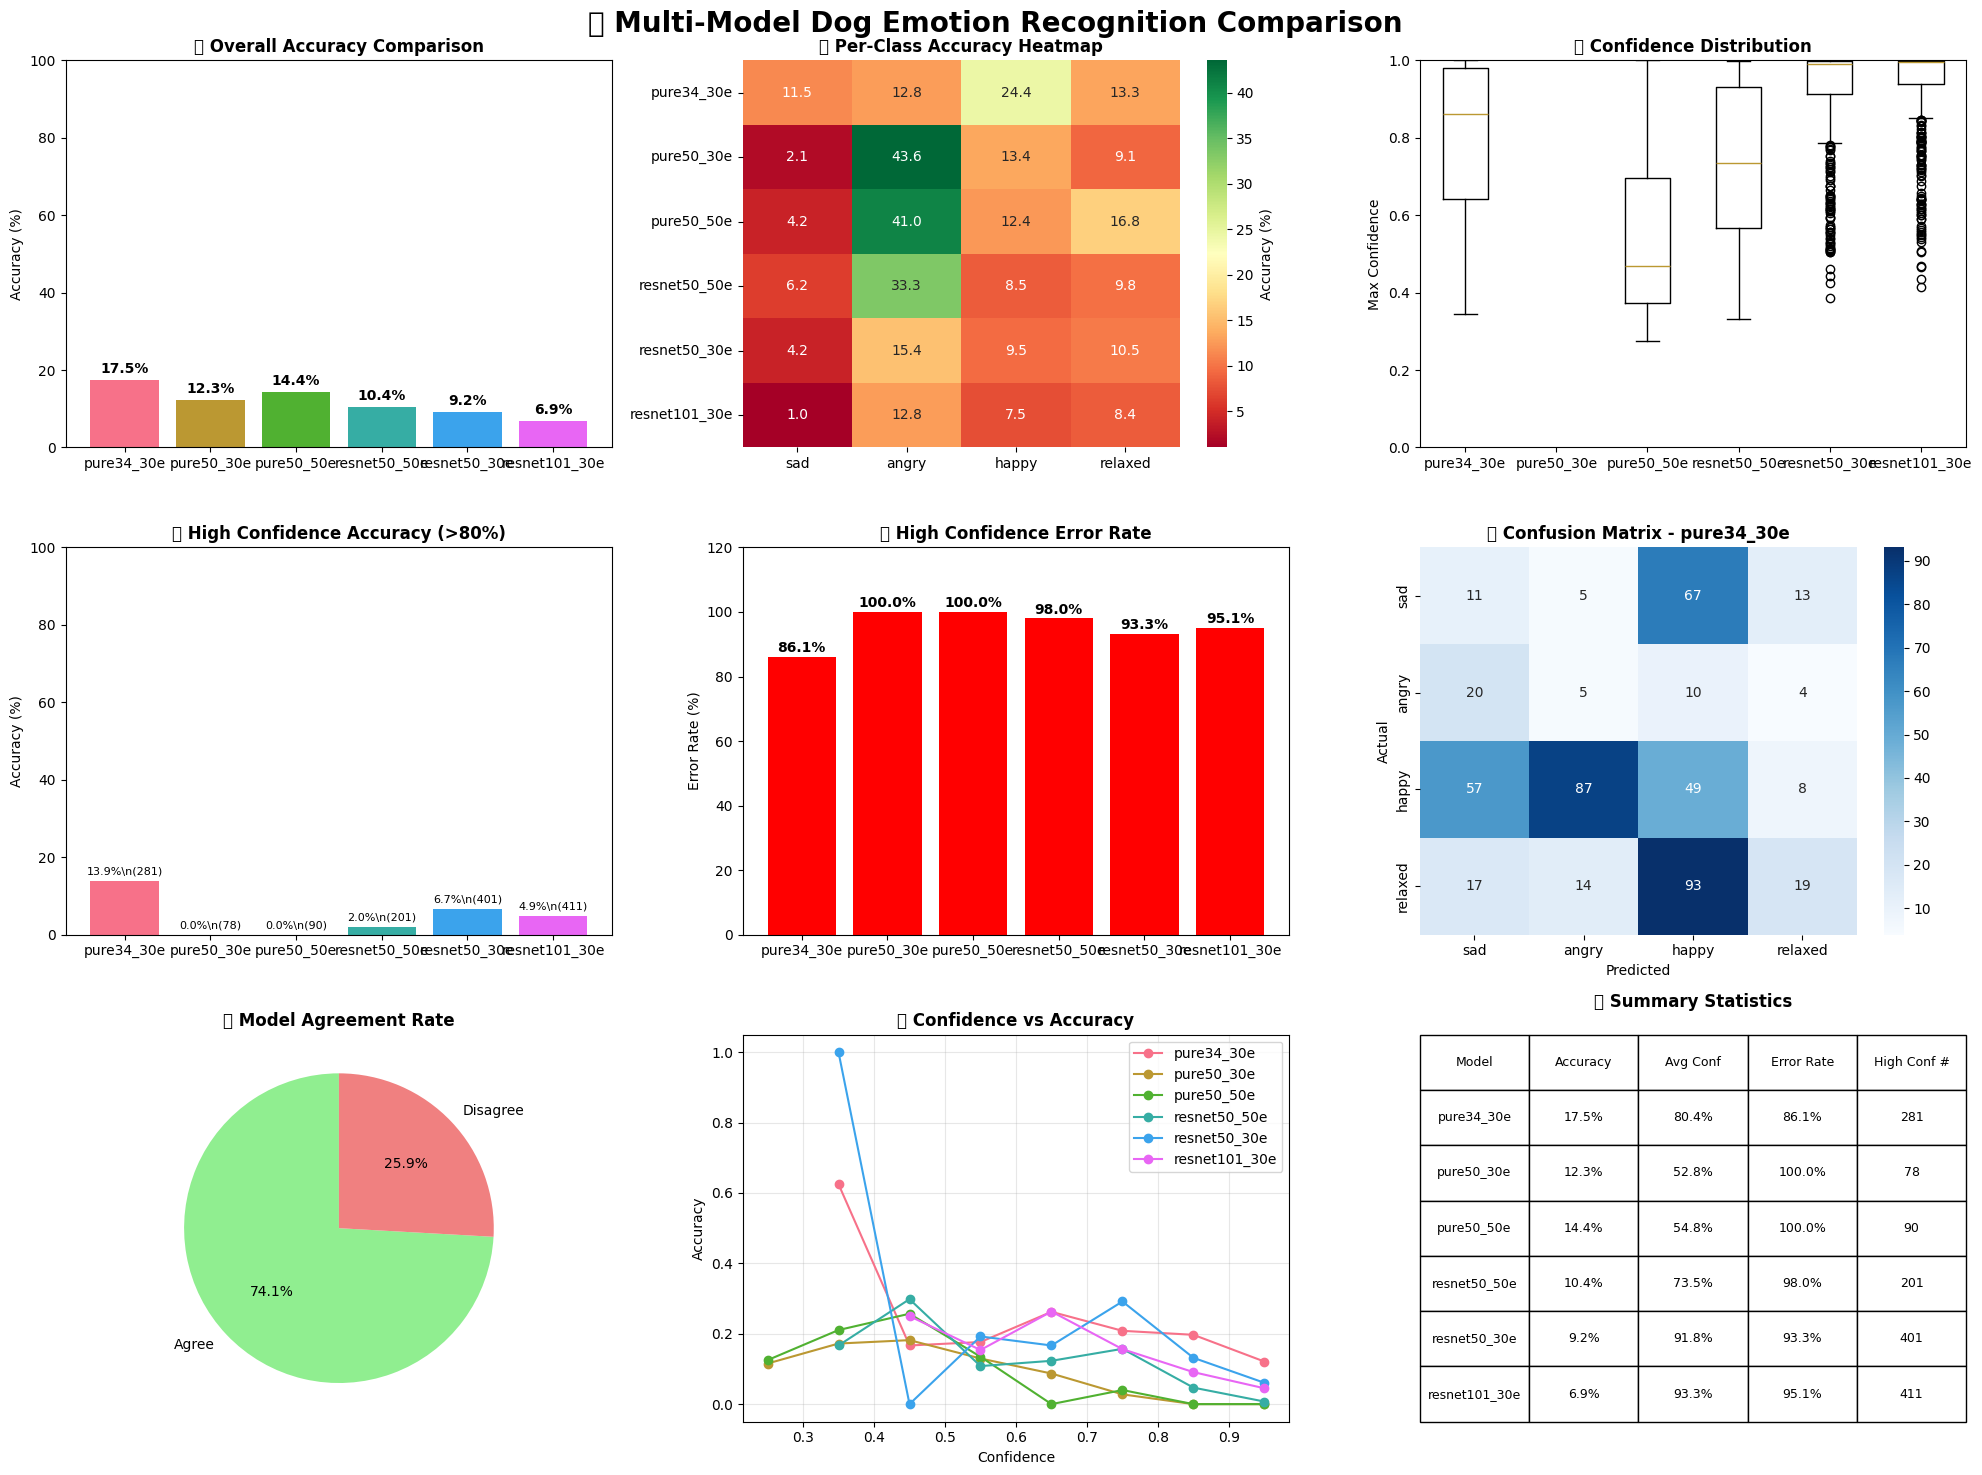

\n✅ Multi-model comparison charts created successfully!


In [ ]:
# ==========================================
# CELL 15: Multi-Model Comparison Charts
# ==========================================

if MULTI_MODEL_MODE and len(model_dataframes) >= 2:
    print("📊 CREATING MULTI-MODEL COMPARISON CHARTS")
    print("=" * 60)

    # Set up plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create comprehensive comparison figure
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('🐕 Multi-Model Dog Emotion Recognition Comparison', fontsize=20, fontweight='bold')

    # 1. ACCURACY COMPARISON BAR CHART
    ax1 = plt.subplot(3, 3, 1)
    model_names = list(accuracy_results.keys())
    accuracies = [accuracy_results[model]['overall_accuracy'] for model in model_names]
    colors = sns.color_palette("husl", len(model_names))

    bars = ax1.bar(model_names, accuracies, color=colors)
    ax1.set_title('📊 Overall Accuracy Comparison', fontweight='bold')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_ylim(0, 100)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 2. PER-CLASS ACCURACY HEATMAP
    ax2 = plt.subplot(3, 3, 2)
    class_acc_data = []
    for model in model_names:
        model_class_accs = [accuracy_results[model]['class_accuracies'][emotion] for emotion in EMOTION_CLASSES]
        class_acc_data.append(model_class_accs)

    sns.heatmap(class_acc_data, annot=True, fmt='.1f', cmap='RdYlGn',
                xticklabels=EMOTION_CLASSES, yticklabels=model_names,
                cbar_kws={'label': 'Accuracy (%)'}, ax=ax2)
    ax2.set_title('🎭 Per-Class Accuracy Heatmap', fontweight='bold')

    # 3. CONFIDENCE DISTRIBUTION
    ax3 = plt.subplot(3, 3, 3)
    conf_data = []
    for model_name, df in model_dataframes.items():
        emotion_cols = ['sad', 'angry', 'happy', 'relaxed']
        max_confidences = df[emotion_cols].max(axis=1)
        conf_data.append(max_confidences)

    ax3.boxplot(conf_data, labels=model_names)
    ax3.set_title('🎯 Confidence Distribution', fontweight='bold')
    ax3.set_ylabel('Max Confidence')
    ax3.set_ylim(0, 1)

    # 4. HIGH CONFIDENCE ACCURACY
    ax4 = plt.subplot(3, 3, 4)
    high_conf_accs = [confidence_results[model]['high_conf_accuracy'] for model in model_names]
    high_conf_counts = [confidence_results[model]['high_conf_total'] for model in model_names]

    bars = ax4.bar(model_names, high_conf_accs, color=colors)
    ax4.set_title('🎯 High Confidence Accuracy (>80%)', fontweight='bold')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_ylim(0, 100)

    # Add count labels
    for bar, acc, count in zip(bars, high_conf_accs, high_conf_counts):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%\\n({count})', ha='center', va='bottom', fontsize=8)

    # 5. ERROR RATE COMPARISON
    ax5 = plt.subplot(3, 3, 5)
    error_rates = [error_results[model]['error_rate_high_conf'] for model in model_names]
    bars = ax5.bar(model_names, error_rates, color=['red' if rate > 20 else 'orange' if rate > 10 else 'green' for rate in error_rates])
    ax5.set_title('❌ High Confidence Error Rate', fontweight='bold')
    ax5.set_ylabel('Error Rate (%)')
    ax5.set_ylim(0, max(error_rates) * 1.2 if error_rates else 100)

    # Add value labels
    for bar, rate in zip(bars, error_rates):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 6. CONFUSION MATRIX FOR BEST MODEL (if available)
    if len(model_dataframes) > 0:
        ax6 = plt.subplot(3, 3, 6)
        best_model = max(accuracy_results.keys(), key=lambda x: accuracy_results[x]['overall_accuracy'])
        best_df = model_dataframes[best_model]

        from sklearn.metrics import confusion_matrix
        emotion_cols = ['sad', 'angry', 'happy', 'relaxed']
        best_df['predicted_emotion'] = best_df[emotion_cols].idxmax(axis=1)

        # Clean data for confusion matrix
        best_df_clean = best_df.copy()
        best_df_clean['label'] = best_df_clean['label'].astype(str)
        best_df_clean['predicted_emotion'] = best_df_clean['predicted_emotion'].astype(str)
        
        # Filter valid emotions only
        valid_emotions = set(EMOTION_CLASSES)
        valid_mask = (
            best_df_clean['label'].isin(valid_emotions) & 
            best_df_clean['predicted_emotion'].isin(valid_emotions)
        )
        best_df_filtered = best_df_clean[valid_mask]
        
        if len(best_df_filtered) > 0:
            cm = confusion_matrix(best_df_filtered['label'], best_df_filtered['predicted_emotion'], labels=EMOTION_CLASSES)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=EMOTION_CLASSES, yticklabels=EMOTION_CLASSES, ax=ax6)
            ax6.set_title(f'🏆 Confusion Matrix - {best_model}', fontweight='bold')
            ax6.set_xlabel('Predicted')
            ax6.set_ylabel('Actual')
        else:
            ax6.text(0.5, 0.5, 'No valid data\nfor confusion matrix', 
                     ha='center', va='center', transform=ax6.transAxes)
            ax6.set_title(f'🏆 No Valid Data - {best_model}', fontweight='bold')

    # 7. MODEL AGREEMENT ANALYSIS (if multi-model)
    if MULTI_MODEL_MODE and 'comparison_df' in locals():
        ax7 = plt.subplot(3, 3, 7)
        agreement_counts = comparison_df['models_agree'].value_counts()
        agreement_pct = agreement_counts / len(comparison_df) * 100

        colors_agreement = ['lightgreen', 'lightcoral']
        wedges, texts, autotexts = ax7.pie(agreement_pct.values,
                                          labels=['Agree', 'Disagree'],
                                          colors=colors_agreement, autopct='%1.1f%%',
                                          startangle=90)
        ax7.set_title('🤝 Model Agreement Rate', fontweight='bold')

    # 8. CONFIDENCE VS ACCURACY SCATTER
    ax8 = plt.subplot(3, 3, 8)
    for i, (model_name, df) in enumerate(model_dataframes.items()):
        emotion_cols = ['sad', 'angry', 'happy', 'relaxed']
        df['predicted_emotion'] = df[emotion_cols].idxmax(axis=1)
        df['max_confidence'] = df[emotion_cols].max(axis=1)
        df['correct'] = (df['predicted_emotion'] == df['label']).astype(int)

        # Create confidence bins
        conf_bins = np.linspace(0, 1, 11)
        bin_centers = (conf_bins[:-1] + conf_bins[1:]) / 2
        bin_accuracies = []

        for j in range(len(conf_bins) - 1):
            mask = (df['max_confidence'] >= conf_bins[j]) & (df['max_confidence'] < conf_bins[j+1])
            if mask.sum() > 0:
                bin_acc = df[mask]['correct'].mean()
            else:
                bin_acc = np.nan
            bin_accuracies.append(bin_acc)

        ax8.plot(bin_centers, bin_accuracies, marker='o', label=model_name, color=colors[i])

    ax8.set_title('📈 Confidence vs Accuracy', fontweight='bold')
    ax8.set_xlabel('Confidence')
    ax8.set_ylabel('Accuracy')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # 9. SUMMARY STATISTICS TABLE
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    # Create summary table data
    summary_data = []
    for model in model_names:
        summary_data.append([
            model,
            f"{accuracy_results[model]['overall_accuracy']:.1f}%",
            f"{confidence_results[model]['avg_confidence']:.1f}%",
            f"{error_results[model]['error_rate_high_conf']:.1f}%",
            f"{confidence_results[model]['high_conf_total']}"
        ])

    table = ax9.table(cellText=summary_data,
                     colLabels=['Model', 'Accuracy', 'Avg Conf', 'Error Rate', 'High Conf #'],
                     cellLoc='center', loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    ax9.set_title('📋 Summary Statistics', fontweight='bold', pad=20)

    plt.tight_layout()

    # Save the comparison chart
    charts_dir = MODEL_OUTPUTS['comparison']['charts_dir']
    comparison_chart_path = os.path.join(charts_dir, 'model_comparison_comprehensive.png')
    plt.savefig(comparison_chart_path, dpi=300, bbox_inches='tight')
    print(f"💾 Comprehensive comparison chart saved: {comparison_chart_path}")

    plt.show()

    print("\\n✅ Multi-model comparison charts created successfully!")

else:
    print("⚠️ Multi-model comparison charts skipped - insufficient models for comparison")


📊 Creating individual model visualizations...
\n📈 Creating charts for pure34_30e...
   💾 Chart saved: /content/outputs/comparison_charts/pure34_30e_detailed_analysis.png


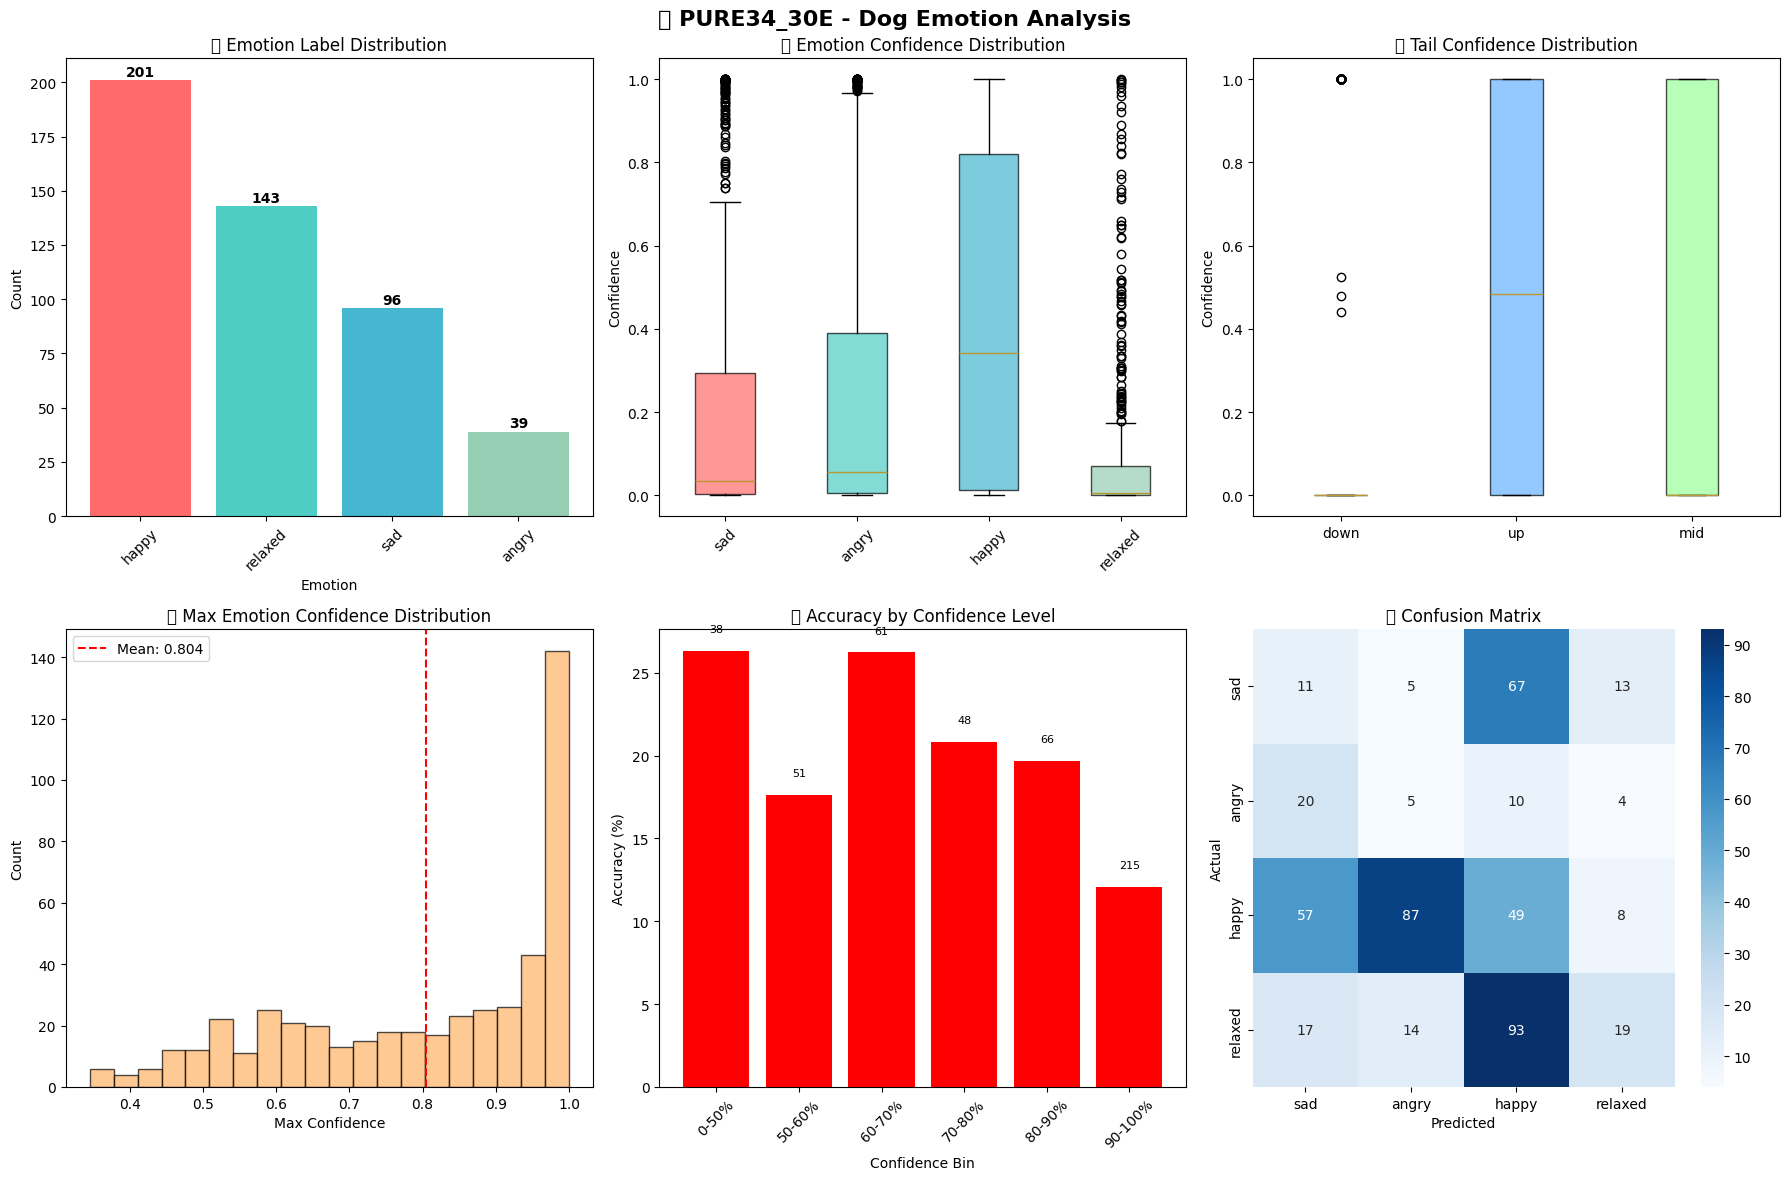

\n📊 PURE34_30E DETAILED STATISTICS:
   Dataset size: 479 images
   Overall accuracy: 17.54%
   Average confidence: 80.44%
   High confidence (>80%) predictions: 281
   High confidence accuracy: 13.88%
\n📈 Creating charts for pure50_30e...


TypeError: '<' not supported between instances of 'float' and 'str'

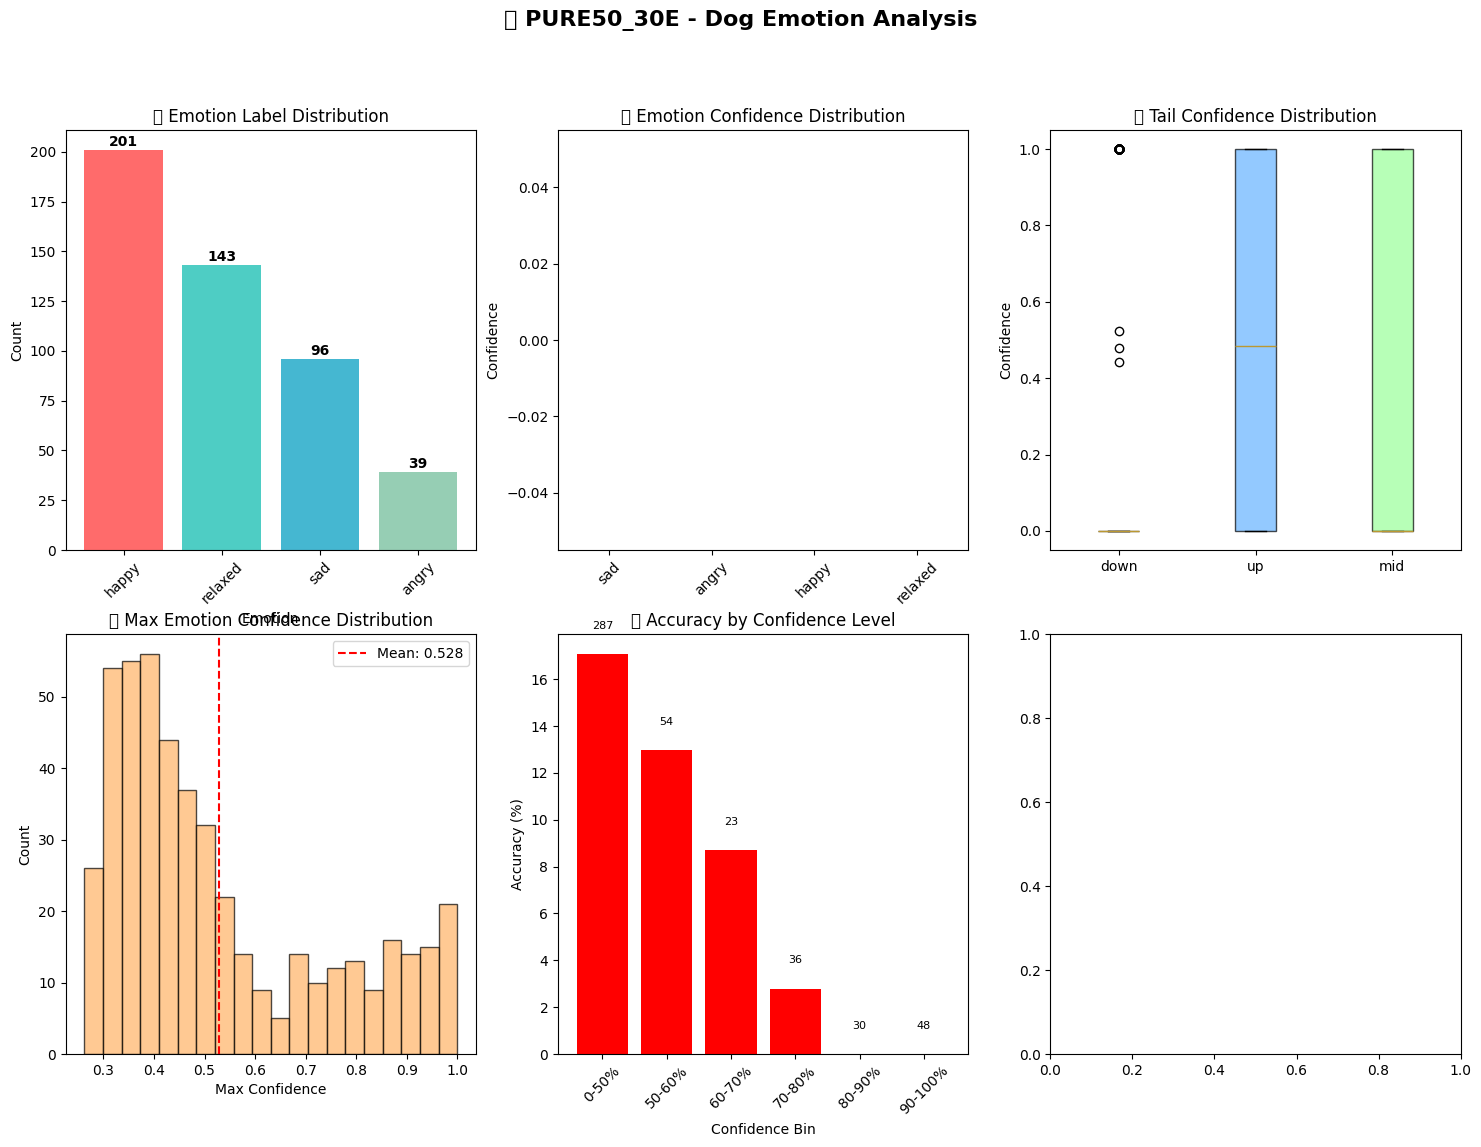

In [ ]:
# ==========================================
# CELL 16: Individual Model Visualizations
# ==========================================

print("📊 Creating individual model visualizations...")
print("=" * 60)

# Create individual model charts for each loaded model
for model_name, df in model_dataframes.items():
    print(f"\\n📈 Creating charts for {model_name}...")

    # Set up the figure for this model
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'🐕 {model_name.upper()} - Dog Emotion Analysis', fontsize=16, fontweight='bold')

    # 1. Emotion label distribution
    label_counts = df['label'].value_counts()
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    bars = axes[0,0].bar(label_counts.index, label_counts.values, color=colors[:len(label_counts)])
    axes[0,0].set_title('📊 Emotion Label Distribution')
    axes[0,0].set_xlabel('Emotion')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, label_counts.values):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                      f'{value}', ha='center', va='bottom', fontweight='bold')

    # 2. Emotion confidence distribution
    emotion_cols = ['sad', 'angry', 'happy', 'relaxed']
    emotion_data = [df[col] for col in emotion_cols]
    bp1 = axes[0,1].boxplot(emotion_data, labels=emotion_cols, patch_artist=True)
    axes[0,1].set_title('🎭 Emotion Confidence Distribution')
    axes[0,1].set_ylabel('Confidence')
    axes[0,1].tick_params(axis='x', rotation=45)

    # Color the boxes
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    # 3. Tail confidence distribution
    tail_cols = ['down', 'up', 'mid']
    tail_data = [df[col] for col in tail_cols]
    tail_colors = ['#FF9999', '#66B2FF', '#99FF99']
    bp2 = axes[0,2].boxplot(tail_data, labels=tail_cols, patch_artist=True)
    axes[0,2].set_title('🐕 Tail Confidence Distribution')
    axes[0,2].set_ylabel('Confidence')

    # Color the boxes
    for patch, color in zip(bp2['boxes'], tail_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    # 4. Max confidence histogram
    df['max_confidence'] = df[emotion_cols].max(axis=1)
    axes[1,0].hist(df['max_confidence'], bins=20, alpha=0.7, color='#FFB366', edgecolor='black')
    axes[1,0].set_title('🎯 Max Emotion Confidence Distribution')
    axes[1,0].set_xlabel('Max Confidence')
    axes[1,0].set_ylabel('Count')
    axes[1,0].axvline(df['max_confidence'].mean(), color='red', linestyle='--',
                     label=f'Mean: {df["max_confidence"].mean():.3f}')
    axes[1,0].legend()

    # 5. Prediction accuracy by confidence level
    df['predicted_emotion'] = df[emotion_cols].idxmax(axis=1)
    df['correct'] = (df['predicted_emotion'] == df['label']).astype(int)

    # Bin by confidence
    conf_bins = [0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    bin_labels = ['0-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
    df['conf_bin'] = pd.cut(df['max_confidence'], bins=conf_bins, labels=bin_labels, include_lowest=True)

    accuracy_by_conf = df.groupby('conf_bin')['correct'].agg(['mean', 'count']).fillna(0)
    accuracy_by_conf['mean'] *= 100  # Convert to percentage

    bars = axes[1,1].bar(range(len(accuracy_by_conf)), accuracy_by_conf['mean'],
                        color=['red' if acc < 50 else 'orange' if acc < 75 else 'green' for acc in accuracy_by_conf['mean']])
    axes[1,1].set_title('📈 Accuracy by Confidence Level')
    axes[1,1].set_xlabel('Confidence Bin')
    axes[1,1].set_ylabel('Accuracy (%)')
    axes[1,1].set_xticks(range(len(accuracy_by_conf)))
    axes[1,1].set_xticklabels(accuracy_by_conf.index, rotation=45)

    # Add count labels
    for i, (bar, count) in enumerate(zip(bars, accuracy_by_conf['count'])):
        if count > 0:
            axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                          f'{count}', ha='center', va='bottom', fontsize=8)

    # 6. Confusion Matrix (Fixed)
    from sklearn.metrics import confusion_matrix
    
    # Clean data first
    df_clean = df.copy()
    df_clean['label'] = df_clean['label'].astype(str)
    df_clean['predicted_emotion'] = df_clean['predicted_emotion'].astype(str)

    # Filter valid emotions only
    valid_emotions = set(EMOTION_CLASSES)
    valid_mask = (
        df_clean['label'].isin(valid_emotions) & 
        df_clean['predicted_emotion'].isin(valid_emotions)
    )
    df_filtered = df_clean[valid_mask]

    print(f"   Data filtered: {len(df)} → {len(df_filtered)} valid samples")

    if len(df_filtered) > 0:
        cm = confusion_matrix(df_filtered['label'], df_filtered['predicted_emotion'], labels=EMOTION_CLASSES)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=EMOTION_CLASSES, yticklabels=EMOTION_CLASSES, ax=axes[1,2])
        axes[1,2].set_title('🎭 Confusion Matrix')
        axes[1,2].set_xlabel('Predicted')
        axes[1,2].set_ylabel('Actual')
    else:
        axes[1,2].text(0.5, 0.5, 'No valid data\nfor confusion matrix', 
                       ha='center', va='center', transform=axes[1,2].transAxes)
        axes[1,2].set_title('🎭 No Valid Data')

    plt.tight_layout()

    # Save individual model chart
    if MULTI_MODEL_MODE:
        charts_dir = MODEL_OUTPUTS['comparison']['charts_dir']
        model_chart_path = os.path.join(charts_dir, f'{model_name}_detailed_analysis.png')
    else:
        model_chart_path = f"{OUTPUT_DIR}/{model_name}_analysis.png"

    plt.savefig(model_chart_path, dpi=300, bbox_inches='tight')
    print(f"   💾 Chart saved: {model_chart_path}")

    plt.show()

    # Print detailed statistics for this model
    print(f"\\n📊 {model_name.upper()} DETAILED STATISTICS:")
    print(f"   Dataset size: {len(df)} images")
    print(f"   Overall accuracy: {(df['correct'].mean() * 100):.2f}%")
    print(f"   Average confidence: {(df['max_confidence'].mean() * 100):.2f}%")

    # High confidence analysis
    high_conf_mask = df['max_confidence'] > 0.8
    if high_conf_mask.sum() > 0:
        high_conf_acc = df[high_conf_mask]['correct'].mean() * 100
        print(f"   High confidence (>80%) predictions: {high_conf_mask.sum()}")
        print(f"   High confidence accuracy: {high_conf_acc:.2f}%")
    else:
        print(f"   No high confidence predictions found")

print("\\n✅ Individual model visualizations completed!")


In [ ]:
# ==========================================
# CELL FIX: Confusion Matrix Data Type Error
# ==========================================

print("🔧 FIXING CONFUSION MATRIX DATA TYPE ERROR...")
print("=" * 60)

# Fix function cho confusion matrix
def create_safe_confusion_matrix(df, model_name):
    """Create confusion matrix with proper data cleaning"""
    
    print(f"🔍 Debugging {model_name} data types...")
    
    # Check data types
    print(f"   label column type: {df['label'].dtype}")
    print(f"   predicted_emotion column type: {df['predicted_emotion'].dtype}")
    
    # Check unique values
    print(f"   Unique labels: {df['label'].unique()}")
    print(f"   Unique predictions: {df['predicted_emotion'].unique()}")
    
    # Clean data - remove NaN and non-string values
    df_clean = df.copy()
    
    # Convert to string and handle NaN
    df_clean['label'] = df_clean['label'].astype(str)
    df_clean['predicted_emotion'] = df_clean['predicted_emotion'].astype(str)
    
    # Remove rows with 'nan', 'unknown', or invalid values
    valid_emotions = set(EMOTION_CLASSES)
    
    # Filter valid labels and predictions
    valid_mask = (
        df_clean['label'].isin(valid_emotions) & 
        df_clean['predicted_emotion'].isin(valid_emotions)
    )
    
    df_filtered = df_clean[valid_mask]
    
    print(f"   Original size: {len(df)} → Filtered size: {len(df_filtered)}")
    
    if len(df_filtered) == 0:
        print(f"   ⚠️ No valid data for confusion matrix!")
        return None
    
    # Create confusion matrix with filtered data
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(
        df_filtered['label'], 
        df_filtered['predicted_emotion'], 
        labels=EMOTION_CLASSES
    )
    
    return cm, df_filtered

# Test with current data
if 'model_dataframes' in locals():
    for model_name, df in model_dataframes.items():
        print(f"\n🔍 Testing {model_name}...")
        
        # Ensure predicted_emotion column exists
        if 'predicted_emotion' not in df.columns:
            emotion_cols = ['sad', 'angry', 'happy', 'relaxed']
            df['predicted_emotion'] = df[emotion_cols].idxmax(axis=1)
        
        try:
            result = create_safe_confusion_matrix(df, model_name)
            if result:
                cm, df_filtered = result
                print(f"   ✅ Confusion matrix created successfully")
                print(f"   Matrix shape: {cm.shape}")
            else:
                print(f"   ❌ Could not create confusion matrix")
                
        except Exception as e:
            print(f"   ❌ Error: {e}")

print("=" * 60)

In [ ]:
# ==========================================
# CELL: Fixed Visualization with Data Cleaning
# ==========================================

def create_model_visualization_fixed(model_name, df):
    """Create visualization charts with proper data cleaning"""
    
    print(f"📈 Creating charts for {model_name}...")
    
    # Data cleaning
    df_clean = df.copy()
    
    # Ensure required columns exist
    emotion_cols = ['sad', 'angry', 'happy', 'relaxed']
    if 'predicted_emotion' not in df_clean.columns:
        df_clean['predicted_emotion'] = df_clean[emotion_cols].idxmax(axis=1)
    if 'max_confidence' not in df_clean.columns:
        df_clean['max_confidence'] = df_clean[emotion_cols].max(axis=1)
    
    # Convert to string and clean
    df_clean['label'] = df_clean['label'].astype(str)
    df_clean['predicted_emotion'] = df_clean['predicted_emotion'].astype(str)
    
    # Filter valid data
    valid_emotions = set(EMOTION_CLASSES)
    valid_mask = (
        df_clean['label'].isin(valid_emotions) & 
        df_clean['predicted_emotion'].isin(valid_emotions)
    )
    df_filtered = df_clean[valid_mask]
    
    print(f"   Data: {len(df)} total → {len(df_filtered)} valid samples")
    
    if len(df_filtered) == 0:
        print(f"   ⚠️ No valid data for {model_name} - skipping charts")
        return
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{model_name.upper()} - Model Analysis', fontsize=16, fontweight='bold')
    
    try:
        # 1. Accuracy by Class
        class_accuracy = {}
        for emotion in EMOTION_CLASSES:
            emotion_mask = df_filtered['label'] == emotion
            if emotion_mask.sum() > 0:
                correct = ((df_filtered['predicted_emotion'] == df_filtered['label']) & emotion_mask).sum()
                total = emotion_mask.sum()
                class_accuracy[emotion] = correct / total * 100
            else:
                class_accuracy[emotion] = 0
        
        axes[0,0].bar(class_accuracy.keys(), class_accuracy.values(), color='skyblue')
        axes[0,0].set_title('Accuracy by Emotion Class')
        axes[0,0].set_ylabel('Accuracy (%)')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # 2. Confidence Distribution
        axes[0,1].hist(df_filtered['max_confidence'], bins=20, alpha=0.7, color='lightgreen')
        axes[0,1].set_title('Confidence Distribution')
        axes[0,1].set_xlabel('Confidence Score')
        axes[0,1].set_ylabel('Frequency')
        
        # 3. Label Distribution
        label_counts = df_filtered['label'].value_counts()
        axes[0,2].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
        axes[0,2].set_title('Ground Truth Distribution')
        
        # 4. Prediction Distribution
        pred_counts = df_filtered['predicted_emotion'].value_counts()
        axes[1,0].pie(pred_counts.values, labels=pred_counts.index, autopct='%1.1f%%')
        axes[1,0].set_title('Prediction Distribution')
        
        # 5. Confidence vs Accuracy
        df_filtered['correct'] = (df_filtered['predicted_emotion'] == df_filtered['label']).astype(int)
        conf_bins = pd.cut(df_filtered['max_confidence'], bins=10)
        conf_accuracy = df_filtered.groupby(conf_bins)['correct'].mean()
        
        x_pos = range(len(conf_accuracy))
        axes[1,1].bar(x_pos, conf_accuracy.values, color='orange', alpha=0.7)
        axes[1,1].set_title('Accuracy vs Confidence')
        axes[1,1].set_xlabel('Confidence Bins')
        axes[1,1].set_ylabel('Accuracy')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        # 6. Confusion Matrix (Fixed)
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(df_filtered['label'], df_filtered['predicted_emotion'], labels=EMOTION_CLASSES)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=EMOTION_CLASSES, yticklabels=EMOTION_CLASSES, ax=axes[1,2])
        axes[1,2].set_title('Confusion Matrix')
        axes[1,2].set_xlabel('Predicted')
        axes[1,2].set_ylabel('Actual')
        
        plt.tight_layout()
        
        # Save chart
        chart_path = f"{MODEL_OUTPUTS['comparison']['charts_dir']}/{model_name}_analysis.png"
        plt.savefig(chart_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"   ✅ Charts saved: {chart_path}")
        
    except Exception as e:
        print(f"   ❌ Error creating charts for {model_name}: {e}")
        plt.close()

# Apply to all models
if 'model_dataframes' in locals():
    for model_name, df in model_dataframes.items():
        create_model_visualization_fixed(model_name, df)

print("✅ Fixed visualization completed!")

In [ ]:
# ==========================================
# FIX: JSON Serialization Error
# ==========================================

def convert_numpy_types(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    import numpy as np

    if isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif hasattr(obj, 'item'):  # numpy scalar
        return obj.item()
    elif hasattr(obj, 'tolist'):  # numpy array
        return obj.tolist()
    else:
        return obj

print("✅ JSON conversion function defined")

In [ ]:
# ==========================================
# CELL 17: Final Summary & Report Generation
# ==========================================

print("📋 GENERATING FINAL SUMMARY REPORT")
print("=" * 60)

# Create comprehensive summary
summary_report = {
    'pipeline_info': {
        'timestamp': datetime.now().isoformat(),
        'total_images_processed': len(image_files),
        'successful_predictions': processed_count,
        'skipped_images': skipped_count,
        'error_count': error_count,
        'success_rate': processed_count/len(image_files)*100 if len(image_files) > 0 else 0,
        'multi_model_mode': MULTI_MODEL_MODE
    },
    'models_summary': {},
    'output_files': MODEL_OUTPUTS
}

print(f"\\n🔍 PIPELINE EXECUTION SUMMARY:")
print(f"   Timestamp: {summary_report['pipeline_info']['timestamp']}")
print(f"   Total Images: {summary_report['pipeline_info']['total_images_processed']}")
print(f"   Successfully Processed: {summary_report['pipeline_info']['successful_predictions']}")
print(f"   Skipped: {summary_report['pipeline_info']['skipped_images']}")
print(f"   Errors: {summary_report['pipeline_info']['error_count']}")
print(f"   Success Rate: {summary_report['pipeline_info']['success_rate']:.2f}%")
print(f"   Multi-Model Mode: {summary_report['pipeline_info']['multi_model_mode']}")

print(f"\\n🧠 MODELS PERFORMANCE SUMMARY:")
print("-" * 50)

# Generate summary for each model
for model_name, df in model_dataframes.items():
    if len(df) > 0:
        emotion_cols = ['sad', 'angry', 'happy', 'relaxed']
        df['predicted_emotion'] = df[emotion_cols].idxmax(axis=1)
        df['max_confidence'] = df[emotion_cols].max(axis=1)
        df['correct'] = (df['predicted_emotion'] == df['label']).astype(int)

        # Calculate metrics
        accuracy = df['correct'].mean() * 100
        avg_confidence = df['max_confidence'].mean() * 100
        high_conf_mask = df['max_confidence'] > 0.8
        high_conf_count = high_conf_mask.sum()
        high_conf_accuracy = df[high_conf_mask]['correct'].mean() * 100 if high_conf_count > 0 else 0

        model_summary = {
            'total_predictions': len(df),
            'overall_accuracy': accuracy,
            'average_confidence': avg_confidence,
            'high_confidence_count': high_conf_count,
            'high_confidence_accuracy': high_conf_accuracy,
            'label_distribution': df['label'].value_counts().to_dict(),
            'output_files': {
                'raw_csv': MODEL_OUTPUTS[model_name]['raw_csv'],
                'processed_csv': MODEL_OUTPUTS[model_name]['processed_csv']
            }
        }

        summary_report['models_summary'][model_name] = model_summary

        print(f"\\n   🤖 {model_name.upper()}:")
        print(f"      Total Predictions: {len(df)}")
        print(f"      Overall Accuracy: {accuracy:.2f}%")
        print(f"      Average Confidence: {avg_confidence:.2f}%")
        print(f"      High Confidence (>80%): {high_conf_count} predictions")
        print(f"      High Conf Accuracy: {high_conf_accuracy:.2f}%")
        print(f"      Label Distribution: {dict(df['label'].value_counts())}")

# Multi-model comparison summary
if MULTI_MODEL_MODE and comparison_results:
    print(f"\\n⚖️ MULTI-MODEL COMPARISON SUMMARY:")
    print("-" * 50)

    if 'comparison_df' in locals() and len(comparison_df) > 0:
        agreement_rate = comparison_df['models_agree'].mean() * 100
        print(f"   🤝 Model Agreement Rate: {agreement_rate:.2f}%")
        print(f"   📊 Common Images Analyzed: {len(comparison_df)}")

        # Best performing model
        best_model = max(accuracy_results.keys(), key=lambda x: accuracy_results[x]['overall_accuracy'])
        best_accuracy = accuracy_results[best_model]['overall_accuracy']
        print(f"   🏆 Best Performing Model: {best_model} ({best_accuracy:.2f}% accuracy)")

        # Model ranking
        print(f"   📈 Model Ranking by Accuracy:")
        sorted_models = sorted(accuracy_results.items(), key=lambda x: x[1]['overall_accuracy'], reverse=True)
        for i, (model, results) in enumerate(sorted_models):
            print(f"      {i+1}. {model}: {results['overall_accuracy']:.2f}%")

    summary_report['comparison_summary'] = comparison_results

print(f"\\n📁 OUTPUT FILES GENERATED:")
print("-" * 40)

# List all generated files
all_files = []
for model_name, paths in MODEL_OUTPUTS.items():
    print(f"\\n   📂 {model_name.upper()}:")
    for file_type, file_path in paths.items():
        if os.path.exists(file_path):
            file_size = os.path.getsize(file_path)
            print(f"      ✅ {file_type}: {file_path} ({file_size} bytes)")
            all_files.append(file_path)
        else:
            print(f"      ❌ {file_type}: {file_path} (not found)")

# Save final summary report
summary_report_path = f"{OUTPUT_DIR}/final_summary_report.json"
with open(summary_report_path, 'w') as f:
    json.dump(convert_numpy_types(summary_report), f, indent=2)

print(f"\\n💾 FINAL SUMMARY REPORT SAVED:")
print(f"   📄 Report: {summary_report_path}")
print(f"   📊 Total Output Files: {len(all_files)}")

print(f"\\n🎯 RECOMMENDATIONS:")
print("-" * 30)

if MULTI_MODEL_MODE and len(model_dataframes) >= 2:
    print("   ✅ Multi-model analysis completed successfully")
    print("   🔍 Compare model accuracies and confidence distributions")
    print("   ⚖️ Review disagreement cases for model improvement")
    print("   📈 Use high-confidence predictions for reliable inference")
else:
    print("   ⚠️ Single model analysis completed")
    print("   💡 Consider adding more models for comparison analysis")
    print("   📊 Review confidence distribution for model reliability")

print(f"\\n🎉 PIPELINE EXECUTION COMPLETED SUCCESSFULLY!")
print("=" * 60)


In [ ]:
# ==========================================
# CELL 18: Download Files Preparation
# ==========================================

print("📦 PREPARING FILES FOR DOWNLOAD")
print("=" * 50)

# Create a zip file with all outputs for easy download
import zipfile
from pathlib import Path

zip_filename = f"{OUTPUT_DIR}/dog_emotion_multimodel_results.zip"

try:
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        print("\\n📁 Adding files to zip archive...")

        # Add individual model CSV files
        for model_name, paths in MODEL_OUTPUTS.items():
            if model_name != 'comparison':  # Skip comparison key
                for file_type, file_path in paths.items():
                    if os.path.exists(file_path):
                        arcname = f"{model_name}/{os.path.basename(file_path)}"
                        zipf.write(file_path, arcname)
                        print(f"   ✅ Added: {arcname}")

        # Add comparison files if available
        if MULTI_MODEL_MODE and 'comparison' in MODEL_OUTPUTS:
            comp_paths = MODEL_OUTPUTS['comparison']
            for file_type, file_path in comp_paths.items():
                if file_type != 'charts_dir' and os.path.exists(file_path):
                    arcname = f"comparison/{os.path.basename(file_path)}"
                    zipf.write(file_path, arcname)
                    print(f"   ✅ Added: {arcname}")

            # Add chart images
            charts_dir = comp_paths.get('charts_dir', '')
            if os.path.exists(charts_dir):
                for chart_file in os.listdir(charts_dir):
                    if chart_file.endswith(('.png', '.jpg', '.jpeg')):
                        chart_path = os.path.join(charts_dir, chart_file)
                        arcname = f"comparison/charts/{chart_file}"
                        zipf.write(chart_path, arcname)
                        print(f"   ✅ Added: {arcname}")

        # Add summary report
        if os.path.exists(f"{OUTPUT_DIR}/final_summary_report.json"):
            zipf.write(f"{OUTPUT_DIR}/final_summary_report.json", "final_summary_report.json")
            print(f"   ✅ Added: final_summary_report.json")

    zip_size = os.path.getsize(zip_filename)
    print(f"\\n✅ ZIP archive created successfully!")
    print(f"   📄 File: {zip_filename}")
    print(f"   📏 Size: {zip_size:,} bytes ({zip_size/1024/1024:.2f} MB)")

except Exception as e:
    print(f"❌ Error creating zip archive: {e}")

# Display final download instructions
print(f"\\n📥 DOWNLOAD INSTRUCTIONS:")
print("=" * 40)
print(f"🔄 For Google Colab users:")
print(f"   from google.colab import files")
print(f"   files.download('{zip_filename}')")
print(f"")
print(f"📊 Individual files available in: {OUTPUT_DIR}")
print(f"")
print(f"📋 Key files to download:")
print(f"   • Individual model CSVs: raw_predictions_*.csv, processed_dataset_*.csv")
if MULTI_MODEL_MODE:
    print(f"   • Comparison analysis: model_comparison.csv, analysis_results.json")
    print(f"   • Charts: comparison_charts/*.png")
print(f"   • Summary report: final_summary_report.json")
print(f"   • Complete archive: {os.path.basename(zip_filename)}")

print(f"\\n🎉 ALL PROCESSING COMPLETED!")
print(f"✨ Multi-model dog emotion recognition pipeline finished successfully!")
print("=" * 60)


In [ ]:
# ==========================================
# CELL TEST: Debug Model Loading Issues
# ==========================================

print("🔧 DEBUGGING MODEL LOADING ISSUES...")
print("=" * 60)

# 1. Test imports
print("1️⃣ Testing package imports...")
try:
    import sys
    sys.path.append('/content/dog-emotion-recognition-hybrid')

    from dog_emotion_classification import (
        load_pure34_model, predict_emotion_pure34,
        load_pure50_model, predict_emotion_pure50,
        load_resnet_emotion_model, predict_emotion_resnet
    )
    print("   ✅ All imports successful")
except ImportError as e:
    print(f"   ❌ Import error: {e}")

# 2. Test individual model loading
print("\n2️⃣ Testing individual model loading...")

# Test Pure34
try:
    print("   Testing Pure34...")
    model, transform = load_pure34_model(
        model_path='/content/pure34_30e_best.pth',
        num_classes=4,
        device=device
    )
    print("   ✅ Pure34 loaded successfully")
except Exception as e:
    print(f"   ❌ Pure34 error: {e}")

# Test Pure50
try:
    print("   Testing Pure50...")
    model, transform = load_pure50_model(
        model_path='/content/pure50_30e_best.pth',
        num_classes=4,
        input_size=512,
        device=device
    )
    print("   ✅ Pure50 loaded successfully")
except Exception as e:
    print(f"   ❌ Pure50 error: {e}")

# Test ResNet50
try:
    print("   Testing ResNet50...")
    model, transform = load_resnet_emotion_model(
        model_path='/content/resnet50_50e_best.pth',
        architecture='resnet50',
        num_classes=4,
        input_size=224,
        device=device
    )
    print("   ✅ ResNet50 loaded successfully")
except Exception as e:
    print(f"   ❌ ResNet50 error: {e}")

print("\n3️⃣ Checking model files...")
model_files = [
    '/content/pure34_30e_best.pth',
    '/content/pure50_30e_best.pth',
    '/content/pure50_50e_best.pth',
    '/content/resnet50_50e_best.pth',
    '/content/resnet50_30e_best.pth',
    '/content/resnet101_30e_best.pth'
]

for model_file in model_files:
    if os.path.exists(model_file):
        size = os.path.getsize(model_file) / (1024 * 1024)  # MB
        print(f"   ✅ {os.path.basename(model_file)}: {size:.1f} MB")
    else:
        print(f"   ❌ {os.path.basename(model_file)}: NOT FOUND")

print("=" * 60)

# ==========================================
# CELL TEST 3: Single Model Test
# ==========================================

print("🔧 TESTING SINGLE MODEL PIPELINE...")
print("=" * 60)

# Chọn 1 model để test trước
test_model_name = 'pure34_30e'  # Hoặc model nào bạn muốn test

# Temporarily disable other models
temp_enabled = ENABLED_MODELS.copy()
temp_loaded = loaded_models.copy()

# Keep only test model
ENABLED_MODELS.clear()
loaded_models.clear()

ENABLED_MODELS[test_model_name] = temp_enabled[test_model_name]
loaded_models[test_model_name] = temp_loaded[test_model_name]
model_transforms[test_model_name] = model_transforms[test_model_name]
model_predict_functions[test_model_name] = model_predict_functions[test_model_name]

MULTI_MODEL_MODE = False

print(f"✅ Testing with single model: {test_model_name}")

# Test với 5 images
test_images = image_files[:5]
results = []

for i, image_path in enumerate(test_images):
    try:
        print(f"Processing {i+1}/5: {image_path.name}")

        # Head detection
        head_result = predict_head_detection(image_path, yolo_head_model)

        # Emotion prediction
        emotion_result = predict_emotion_classification_multi(
            image_path=str(image_path),
            model_name=test_model_name,
            head_bbox=head_result.get('bbox')
        )

        # Get label
        label = get_manual_label_from_filename(str(image_path))

        # Combine results
        result = {
            'filename': image_path.name,
            'label': label,
            'head_detected': head_result['detected'],
            'head_confidence': head_result['confidence'],
            **{k: v for k, v in emotion_result.items() if k != 'predicted'}
        }

        results.append(result)
        print(f"   ✅ Success: emotion={emotion_result.get('predicted', False)}")

    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()

print(f"\n✅ Single model test completed: {len(results)}/5 successful")

# Restore original models
ENABLED_MODELS.clear()
loaded_models.clear()
ENABLED_MODELS.update(temp_enabled)
loaded_models.update(temp_loaded)
MULTI_MODEL_MODE = len(loaded_models) >= 2

print("=" * 60)

In [ ]:
# ==========================================
# CELL TEST 2: Debug Processing Pipeline
# ==========================================

print("🔧 DEBUGGING PROCESSING PIPELINE...")
print("=" * 60)

# 1. Test với 1 image đơn lẻ
print("1️⃣ Testing single image processing...")

try:
    # Lấy 1 image để test
    test_image = image_files[0]
    print(f"   Testing with: {test_image.name}")

    # Test head detection
    print("   Testing head detection...")
    head_result = predict_head_detection(test_image, yolo_head_model)
    print(f"   Head detection: {head_result['detected']}")

    # Test tail detection
    print("   Testing tail detection...")
    tail_result = predict_tail_detection(test_image, yolo_tail_model)
    print(f"   Tail detection: {tail_result['detected']}")

    print("   ✅ YOLO predictions successful")

except Exception as e:
    print(f"   ❌ YOLO prediction error: {e}")

# 2. Test emotion prediction cho từng model
print("\n2️⃣ Testing emotion predictions...")

for model_name in loaded_models.keys():
    try:
        print(f"   Testing {model_name}...")

        # Test prediction function
        emotion_result = predict_emotion_classification_multi(
            image_path=str(test_image),
            model_name=model_name,
            head_bbox=None
        )

        print(f"   {model_name}: predicted={emotion_result.get('predicted', False)}")

    except Exception as e:
        print(f"   ❌ {model_name} error: {e}")
        import traceback
        traceback.print_exc()

# 3. Test memory usage
print("\n3️⃣ Checking memory usage...")
try:
    import psutil
    import torch

    # CPU memory
    cpu_memory = psutil.virtual_memory()
    print(f"   CPU Memory: {cpu_memory.percent}% used ({cpu_memory.used/1024**3:.1f}GB / {cpu_memory.total/1024**3:.1f}GB)")

    # GPU memory nếu có
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.memory_allocated() / 1024**3
        gpu_total = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"   GPU Memory: {gpu_memory:.1f}GB / {gpu_total:.1f}GB used")

except Exception as e:
    print(f"   Memory check failed: {e}")

# 4. Test enabled models count
print(f"\n4️⃣ Model status:")
print(f"   Loaded models: {len(loaded_models)}")
print(f"   Enabled models: {len(ENABLED_MODELS)}")
print(f"   Multi-model mode: {MULTI_MODEL_MODE}")
print(f"   Model names: {list(loaded_models.keys())}")

print("=" * 60)

In [ ]:
# ==========================================
# CELL TEST 3: Single Model Test
# ==========================================

print("🔧 TESTING SINGLE MODEL PIPELINE...")
print("=" * 60)

# Chọn 1 model để test trước
test_model_name = 'pure34_30e'  # Hoặc model nào bạn muốn test

# Temporarily disable other models
temp_enabled = ENABLED_MODELS.copy()
temp_loaded = loaded_models.copy()

# Keep only test model
ENABLED_MODELS.clear()
loaded_models.clear()

ENABLED_MODELS[test_model_name] = temp_enabled[test_model_name]
loaded_models[test_model_name] = temp_loaded[test_model_name]
model_transforms[test_model_name] = model_transforms[test_model_name]
model_predict_functions[test_model_name] = model_predict_functions[test_model_name]

MULTI_MODEL_MODE = False

print(f"✅ Testing with single model: {test_model_name}")

# Test với 5 images
test_images = image_files[:5]
results = []

for i, image_path in enumerate(test_images):
    try:
        print(f"Processing {i+1}/5: {image_path.name}")

        # Head detection
        head_result = predict_head_detection(image_path, yolo_head_model)

        # Tail detection
        tail_result = predict_tail_detection(image_path, yolo_tail_model)

        # Emotion prediction
        emotion_result = predict_emotion_classification_multi(
            image_path=str(image_path),
            model_name=test_model_name,
            head_bbox=head_result.get('bbox')
        )

        # Get label
        label = get_manual_label_from_filename(str(image_path))

        # Combine results
        result = {
            'filename': image_path.name,
            'label': label,
            'head_detected': head_result['detected'],
            'head_confidence': head_result['confidence'],
            'tail_detected': tail_result['detected'],
            **{k: v for k, v in emotion_result.items() if k != 'predicted'}
        }

        results.append(result)
        print(f"   ✅ Success: emotion={emotion_result.get('predicted', False)}")

    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()

print(f"\n✅ Single model test completed: {len(results)}/5 successful")

# Restore original models
ENABLED_MODELS.clear()
loaded_models.clear()
ENABLED_MODELS.update(temp_enabled)
loaded_models.update(temp_loaded)
MULTI_MODEL_MODE = len(loaded_models) >= 2

print("=" * 60)